This file is the successor of 'Ite_threshold_analysis_combined_ite_100k'

The following points were added since then:

- the dataset contains now all space entries from the typing study
- more accurate calculation of the thresholds for autocorrection and prediction
- we added a feature to the Gauss-estimation where we show the thresholds in the plot and the amount of overlapping between our classifciations of autocorrections and predictions
- Because the resulting, larger dataset needs more horsepower for preprocessing calculations than jupyter notebook or a single PC without GPUs can offer, we created the file 'Prepare_files_for_analysis_ite_thresholds.py' which 'outsources' the preprocessing (in my case I used the ETH cluster for these kind of calculations) 

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import pylab as plb
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp
import math
#from scipy.stats import norm
from sklearn import mixture
import scipy.stats as stats

In [3]:
log_comb_ite_with_participants = pd.read_csv('log_comb_ite_with_participants_with_user_groups_complete.csv', dtype={'user type': np.unicode_})

In [4]:
log_comb_ite_with_participants = log_comb_ite_with_participants.drop(['Unnamed: 0'],axis=1)
log_comb_ite_with_participants = log_comb_ite_with_participants.dropna()

In [5]:
#log_comb_ite_with_participants

In [6]:
log_combined_ite_1 = pd.read_csv('log_processed_autocorr_and_predict_combined.csv')

In [7]:
log_combined_ite = log_combined_ite_1.loc[log_combined_ite_1['ite'] == 'autocorr_or_predict']

In [8]:
log_combined_ite = log_combined_ite.drop(['ite2'], axis = 1)
log_combined_ite = log_combined_ite.dropna()

In [9]:
log_comb_ite_with_participants_spaces = log_comb_ite_with_participants.loc[log_comb_ite_with_participants['ite_prev'] == 'none']
log_comb_ite_with_participants_spaces = log_comb_ite_with_participants_spaces.dropna()
log_comb_ite_with_participants_ites = log_comb_ite_with_participants.loc[log_comb_ite_with_participants['ite_prev'] != 'none']
log_comb_ite_with_participants_ites = log_comb_ite_with_participants_ites.dropna()

In [10]:
# -*- coding: utf-8 -*-

# Class
class PrintTable:
    def __init__(self, values, captions, widths, aligns):
        if not all([len(values[0]) == len(x) for x in [captions, widths, aligns]]):
            raise Exception()
        self._tablewidth = sum(widths) + 3*(len(captions)-1) + 4
        self._values = values
        self._captions = captions
        self._widths = widths
        self._aligns = aligns

    def print(self):
        self._printTable()

    def _printTable(self):
        formattext_head = ""
        formattext_cell = ""
        for i,v in enumerate(self._widths):
            formattext_head += "{" + str(i) + ":<" + str(v) + "} | "
            formattext_cell += "{" + str(i) + ":" + self._aligns[i] + str(v) + "} | "
        formattext_head = formattext_head[:-3]
        formattext_head = "  " + formattext_head.strip() + "  "
        formattext_cell = formattext_cell[:-3]
        formattext_cell = "  " + formattext_cell.strip() + "  "

        print("-"*self._tablewidth)
        print(formattext_head.format(*self._captions))
        print("-"*self._tablewidth)
        for w in self._values:
            print(formattext_cell.format(*w))
        print("-"*self._tablewidth)

In [11]:
def Apply_Gaussian_mixture_models_2(dataFrame,n_components,x_lim=1300,compare_gmm_to_kde = 0):
    headername = ["Gaussians","Mean","Sigma","Left 90%", "Right 90%", "Left 85%" , "Right 85%"]
    data = [["no {}".format(x+1), x, x*2,x**3,x**4,x**5,x**6] for x in range(n_components)]
    
    #x1 = dataFrame.to_numpy()
    x1 = dataFrame.values
    
    # Remove datapoints where iki < 20 ms
    for i in range(len(x1)):
        if x1[i] <= 20:
            x1[i] = np.nan
    x1 = x1[~np.isnan(x1)]
    
    x2 = x1.reshape(-1,1)
    clf = mixture.GaussianMixture(n_components=n_components, covariance_type='full', max_iter=2000, n_init=10).fit(x2)
    xpdf = np.linspace(0,x_lim,2000)
    xpdf2 = xpdf.reshape(-1,1)
    density=np.exp(clf.score_samples(xpdf2))
    
    # prediction
    df_data = clf.predict_proba(xpdf2)
    df_prob = pd.DataFrame(data=df_data,columns=['Probability gaussian {}'.format(x+1) for x in range(n_components)])
    plt.subplots(1,figsize=(25,12))
    plt.xlim(0,x_lim)
    plt.xticks(range(0,x_lim,100))
    for i in range(n_components):
        df_tmp = df_prob[str('Probability gaussian ' + str(i+1))].to_numpy()
        df_tmp2 = df_prob[str('Probability gaussian ' + str(i+1))].to_numpy()
        plt.plot(xpdf2,df_tmp)
        #count = 0
        for j in range(len(df_tmp2)-1):
            if(df_tmp[j] > 0.85):    
                if df_tmp[j+1] <= 0.85 :
                    print("85: " + str(x_lim*(j/len(df_tmp2))))
            if(df_tmp[j] < 0.85):
                if df_tmp[j+1] >= 0.85 :
                    print("85: " + str(x_lim*(j/len(df_tmp2))))
                if j < 200 and df_tmp[j+1] >= df_tmp[j]:
                    df_tmp2[j] = df_tmp2[j]
                else:
                    df_tmp2[j] = 0
            if(df_tmp[j] > 0.90):    
                if df_tmp[j+1] <= 0.90 :
                    print("90: " + str(x_lim*(j/len(df_tmp2))))
            if(df_tmp[j] < 0.90):
                if df_tmp[j+1] >= 0.90 :
                    print("90: " + str(x_lim*(j/len(df_tmp2))))
                    #count = count + 1
            #count = 0
                #if j > 900:
                #    df_tmp2[j] = df_tmp2[j]
                #if df_tmp[j] < 50  and j > 100 and j < 900:
                #    df_tmp2[j] = 0
        plt.fill_between(xpdf,df_tmp2,alpha=0.2)
    
    if compare_gmm_to_kde == 1:
        fig, axs = plt.subplots(3,figsize=(25,24))
        axs[0].set_xlim(0,x_lim)
        axs[0].set_xticks(range(0,x_lim,100))
        axs[0].hist(x1,700,density=True,alpha=0.4)
        axs[0].plot(xpdf,density,'-r')
    else:
        fig, axs = plt.subplots(1,figsize=(25,12))
        axs.set_xlim(0,x_lim)
        axs.set_xticks(range(0,x_lim,100))
        axs.hist(x1,700,density=True,alpha=0.4)
        axs.plot(xpdf,density,'-r')


    for i in range(clf.n_components):
        pdf = clf.weights_[i] * stats.norm(clf.means_[i,0],np.sqrt(clf.covariances_[i,0])).pdf(xpdf)
        if compare_gmm_to_kde == 1:
            axs[0].fill_between(xpdf,pdf,facecolor='darkblue',edgecolor='none',alpha=0.4)
        else:
            axs.fill_between(xpdf,pdf,facecolor='darkblue',edgecolor='none',alpha=0.4)
        data[i][1] = int(clf.means_[i,0])
        data[i][2] = int(np.sqrt(clf.covariances_[i,0]))
        data[i][3] = int(clf.means_[i,0] - 1.65*np.sqrt(clf.covariances_[i,0]))
        data[i][4] = int(clf.means_[i,0] + 1.65*np.sqrt(clf.covariances_[i,0]))
        data[i][5] = int(clf.means_[i,0] - 1.44*np.sqrt(clf.covariances_[i,0]))
        data[i][6] = int(clf.means_[i,0] + 1.44*np.sqrt(clf.covariances_[i,0]))
    
    if compare_gmm_to_kde == 1:
        axs[1].set_xlim(0,x_lim)
        axs[1].set_xticks(range(0,x_lim,500))
        axs[1].hist(x1,700,density=True,alpha=0.3)
        sns.kdeplot(x1, shade=True,kernel='gau',gridsize=2000,alpha=0.8,ax=axs[1],color='darkorange')
        
        axs[2].set_xlim(0,x_lim)
        axs[2].set_xticks(range(0,x_lim,500))
        sns.kdeplot(x1, shade=True,kernel='gau',gridsize=2000,alpha=0.8,ax=axs[2],color='darkorange')
        axs[2].plot(xpdf,density,'-r')
    
    #PrintTable(data,headername,[10, 10, 10 ,10, 10, 10, 10],["<",">",">",">",">",">",">"]).print()

In [67]:
def Analyze_user_group(dataFrame):
    headername = ["User Group","Sample Size","% Autocorr","% Predict","% Undef.","Threshold Min", "Threshold Max"]
    data = [["{} WPM".format((x+1)*5),0,0,0,0,0,0] for x in range(21)]
    
    thresholds_predict = [396,367,593,442,417,395,397,376,363,367,331,316,291,285,266,266,245,225,300,300]
    thresholds_autocorr = [273,280,396,281,295,293,297,282,276,269,255,245,227,239,225,228,208,205,200,200]
    
    for i in range(20):
        data[i][5] = thresholds_autocorr[i]
        data[i][6] = thresholds_predict[i]
    
    sample_sizes = np.zeros(20)
    predict_percentages = np.zeros(20)
    autocorr_percentages = np.zeros(20)
    
    # Get Sample Size
    for i in range(19):
        data[i][1] = dataFrame.loc[dataFrame['user type 5'] == (i+1)*5].shape[0] 
        sample_sizes[i] = data[i][1]
    data[19][1] = dataFrame.loc[dataFrame['user type 5'] == 99].shape[0]
    sample_sizes[19] = data[19][1]
    
    # Get percentage of autocorrections
    for i in range(19):
        df_autocorr_i = dataFrame.loc[dataFrame['user type 5'] == (i+1)*5]
        data[i][2] = round((df_autocorr_i.loc[df_autocorr_i['iki'] <= thresholds_autocorr[i]].shape[0])/(data[i][1]) * 100,3)
        autocorr_percentages[i] = data[i][2]
    df_autocorr_19 = dataFrame.loc[dataFrame['user type 5'] == 99]
    data[19][2] = round((df_autocorr_19.loc[df_autocorr_19['iki'] <= thresholds_autocorr[19]].shape[0])/(data[19][1]) * 100,3) 
    autocorr_percentages[19] = data[19][2]
    
    # Get percentage of predictions
    for i in range(19):
        df_predict_i = dataFrame.loc[dataFrame['user type 5'] == (i+1)*5]
        data[i][3] = round((df_predict_i.loc[df_predict_i['iki'] >= thresholds_predict[i]].shape[0])/(data[i][1])* 100,3)
        predict_percentages[i] = data[i][3] 
    df_predict_19 = dataFrame.loc[dataFrame['user type 5'] == 99]
    data[19][3] = round((df_predict_19.loc[df_predict_19['iki'] >= thresholds_predict[19]].shape[0])/(data[19][1])* 100,3) 
    predict_percentages[19] = data[19][3]
    
    # Get percentage of undefined entries 
    for i in range(19):
        data[i][4] = round(100 - data[i][2] - data[i][3],3)
        
    # Median values in last row
    data[20][0] = "All users"
    data[20][1] = sample_sizes.sum()
    #data[0][1] + data[1][1] + data[2][1] + data[3][1] + data[4][1] + data[5][1] + data[6][1] + data[7][1] + data[8][1] + data[9][1] + data[10][1] + data[11][1] + data[12][1] + data[13][1] + data[14][1] + data[15][1] + data[16][1] + data[17][1] + data[18][1] + data[19][1]
    weighted_sum_autocorr = 0
    for i in range(20):
        weighted_sum_autocorr = weighted_sum_autocorr + sample_sizes[i]*autocorr_percentages[i]*0.01
    data[20][2] = round((weighted_sum_autocorr/sample_sizes.sum())*100, 3)
    #round((data[0][2] + data[1][2] + data[2][2] + data[3][2] + data[4][2] + data[5][2] + data[6][2] + data[7][2] + data[8][2] + data[9][2] + data[10][2] + data[11][2] + data[12][2] + data[13][2] + data[14][2] + data[15][2] + data[16][2] + data[17][2] + data[18][2] + data[19][2])/20,3)
    weighted_sum_predict = 0
    for i in range(20):
        weighted_sum_predict = weighted_sum_predict + sample_sizes[i]*predict_percentages[i]*0.01
    data[20][3] = round((weighted_sum_predict/sample_sizes.sum())*100, 3)
    #round((data[0][3] + data[1][3] + data[2][3] + data[3][3] + data[4][3] + data[5][3] + data[6][3] + data[7][3] + data[8][3] + data[9][3] + data[10][3] + data[11][3] + data[12][3] + data[13][3] + data[14][3] + data[15][3] + data[16][3] + data[17][3] + data[18][3] + data[19][3])/20,3)
    data[20][4] = round(100 - data[20][2] - data[20][3], 3)
    #round((data[0][4] + data[1][4] + data[2][4] + data[3][4] + data[4][4] + data[5][4] + data[6][4] + data[7][4] + data[8][4] + data[9][4] + data[10][4] + data[11][4] + data[12][4] + data[13][4] + data[14][4] + data[15][4] + data[16][4] + data[17][4] + data[18][4] + data[19][4])/20,3)
    
    
    # Print table
    PrintTable(data,headername,[12, 12, 13, 13, 13, 13, 13],["<",">",">",">",">",">",">"]).print()
    
    

In [68]:
def Analyze_losses_with_old_thresholds(dataFrame):
    headername = ["User Group","Sample Size","% Autocorr","% Predict","% Undef.", "Threshold Min", "Threshold Max"]
    data = [["{} WPM".format((x+1)*5),0,0,0,0,0,0] for x in range(21)]
    
    thresholds_predict = [500]
    thresholds_autocorr = [400]
    
    for i in range(20):
        data[i][5] = thresholds_autocorr[0]
        data[i][6] = thresholds_predict[0]
    
    sample_sizes = np.zeros(20)
    predict_percentages = np.zeros(20)
    autocorr_percentages = np.zeros(20)
    
    # Get Sample Size
    for i in range(19):
        data[i][1] = dataFrame.loc[dataFrame['user type 5'] == (i+1)*5].shape[0] 
        sample_sizes[i] = data[i][1]
    data[19][1] = dataFrame.loc[dataFrame['user type 5'] == 99].shape[0]
    sample_sizes[19] = data[19][1]
    
    # Get percentage of autocorrections
    for i in range(19):
        df_autocorr_i = dataFrame.loc[dataFrame['user type 5'] == (i+1)*5]
        data[i][2] = round((df_autocorr_i.loc[df_autocorr_i['iki'] <= thresholds_autocorr[0]].shape[0])/(data[i][1]) * 100,3)
        autocorr_percentages[i] = data[i][2]
    df_autocorr_19 = dataFrame.loc[dataFrame['user type 5'] == 99]
    data[19][2] = round((df_autocorr_19.loc[df_autocorr_19['iki'] <= thresholds_autocorr[0]].shape[0])/(data[19][1]) * 100,3) 
    autocorr_percentages[19] = data[19][2]
    
    # Get percentage of predictions
    for i in range(19):
        df_predict_i = dataFrame.loc[dataFrame['user type 5'] == (i+1)*5]
        data[i][3] = round((df_predict_i.loc[df_predict_i['iki'] >= thresholds_predict[0]].shape[0])/(data[i][1])* 100,3)
        predict_percentages[i] = data[i][3] 
    df_predict_19 = dataFrame.loc[dataFrame['user type 5'] == 99]
    data[19][3] = round((df_predict_19.loc[df_predict_19['iki'] >= thresholds_predict[0]].shape[0])/(data[19][1])* 100,3) 
    predict_percentages[19] = data[19][3]
    
    # Get percentage of undefined entries 
    for i in range(19):
        data[i][4] = round(100 - data[i][2] - data[i][3],3)
    
    
    
    # Median values in last row
    data[20][0] = "All users"
    
    # Get Sample Size
    data[20][1] = dataFrame.shape[0] 
    
    # Get percentage of autocorrections
    data[20][2] = round((dataFrame.loc[dataFrame['iki'] <= thresholds_autocorr[0]].shape[0])/(data[20][1]) * 100,3) 
    
    # Get percentage of predictions
    data[20][3] = round((dataFrame.loc[dataFrame['iki'] >= thresholds_predict[0]].shape[0])/(data[20][1]) * 100,3) 
    
    # Get percentage of undefined entries 
    data[20][4] = round(100 - data[20][2] - data[20][3],3)
        
    # Print table
    PrintTable(data,headername,[12, 12, 13 ,13, 13, 13, 13],["<",">",">",">",">",">",">"]).print()

85: 16.9
90: 33.8
90: 244.4
85: 261.95
85: 350.35
90: 359.45000000000005


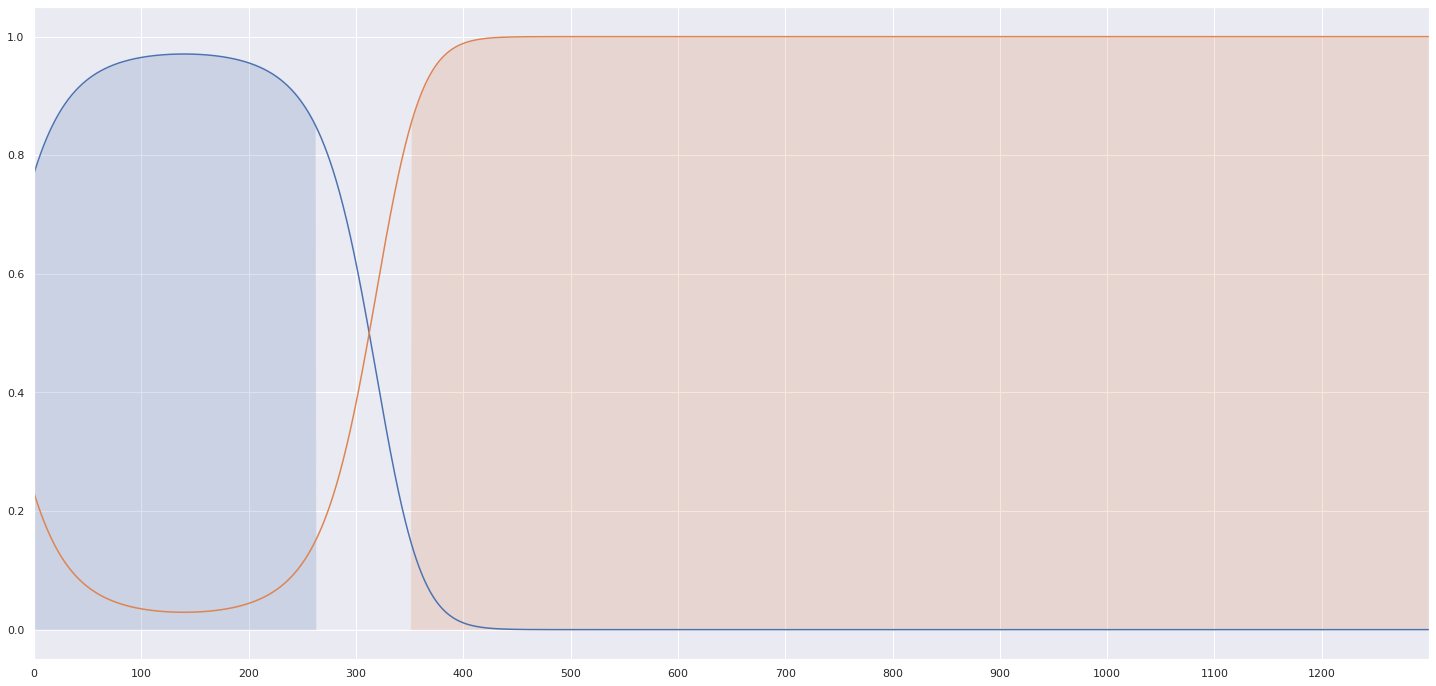

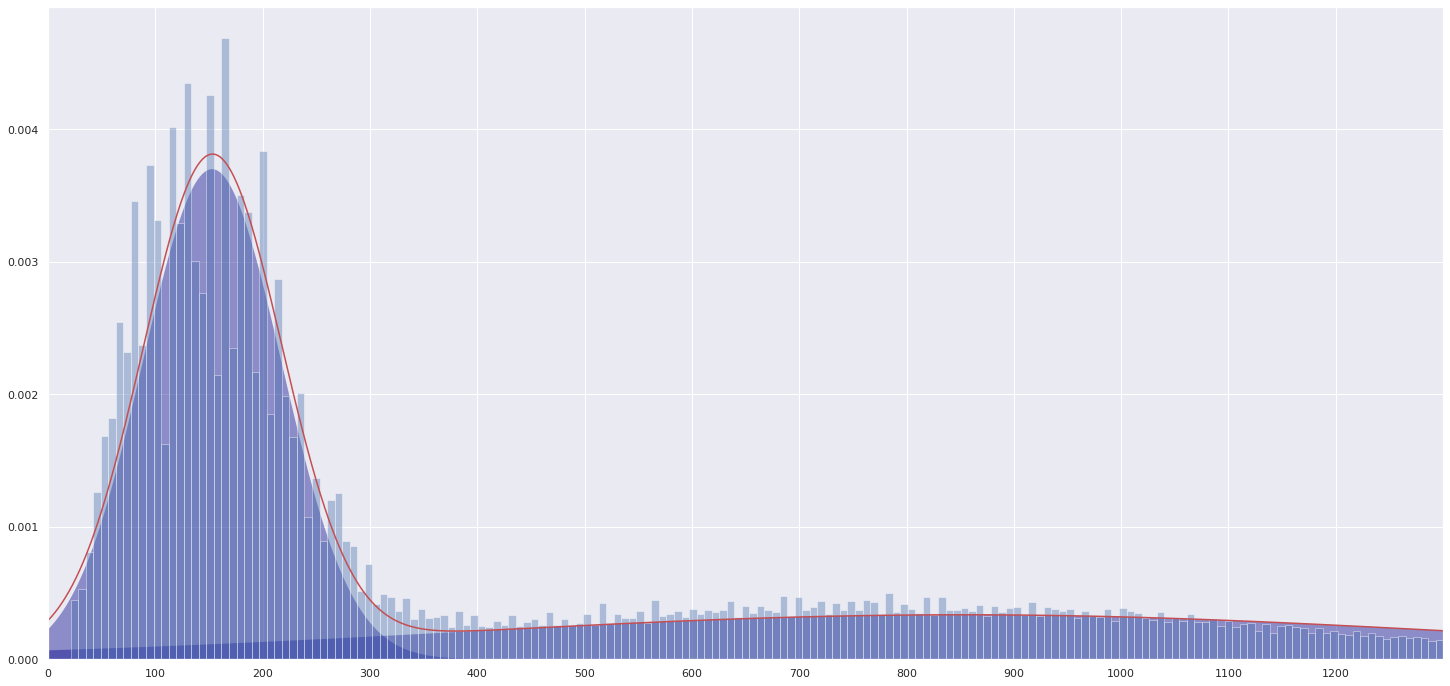

In [64]:
# Kernel density estimation of all autocorrections and predictions
Apply_Gaussian_mixture_models_2(log_combined_ite.iki,2)

90: 6.0
90: 256.5
85: 273.0
85: 1588.5
90: 1636.5
85: 396.0
90: 517.5
90: 894.0
85: 1056.0


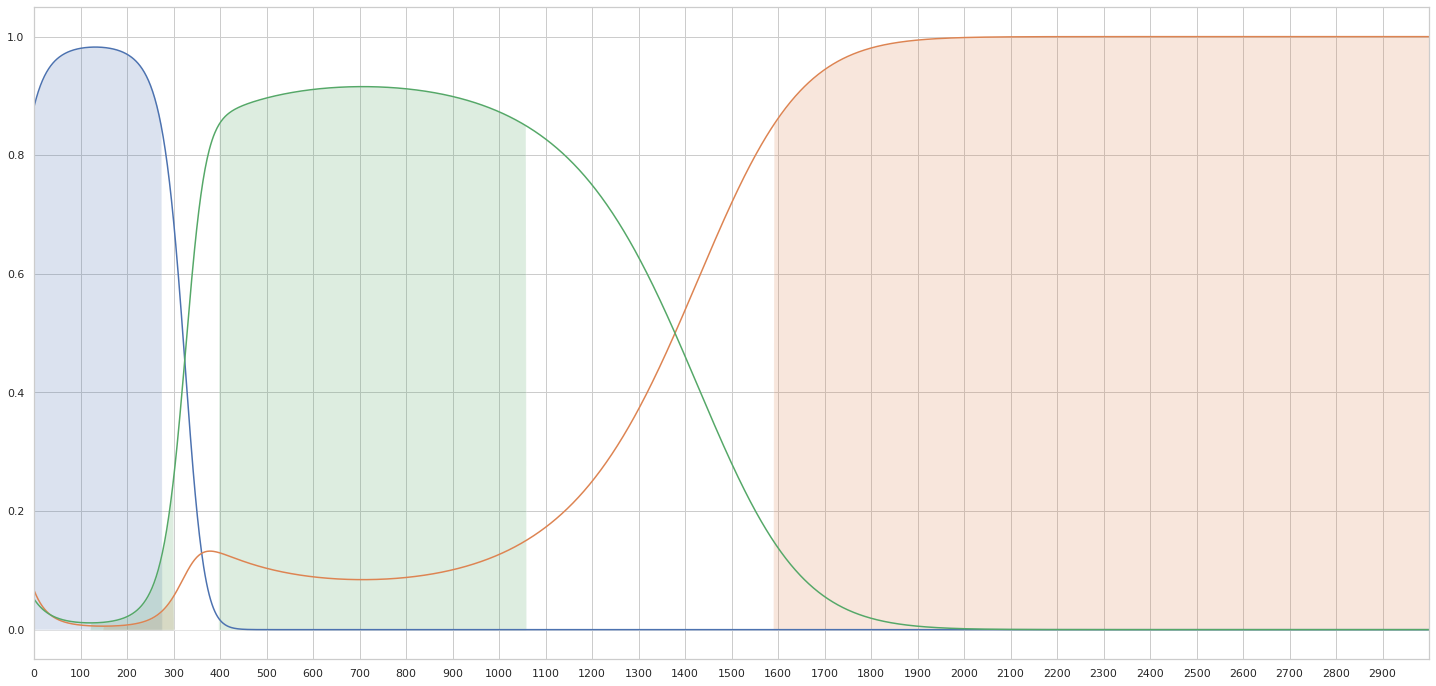

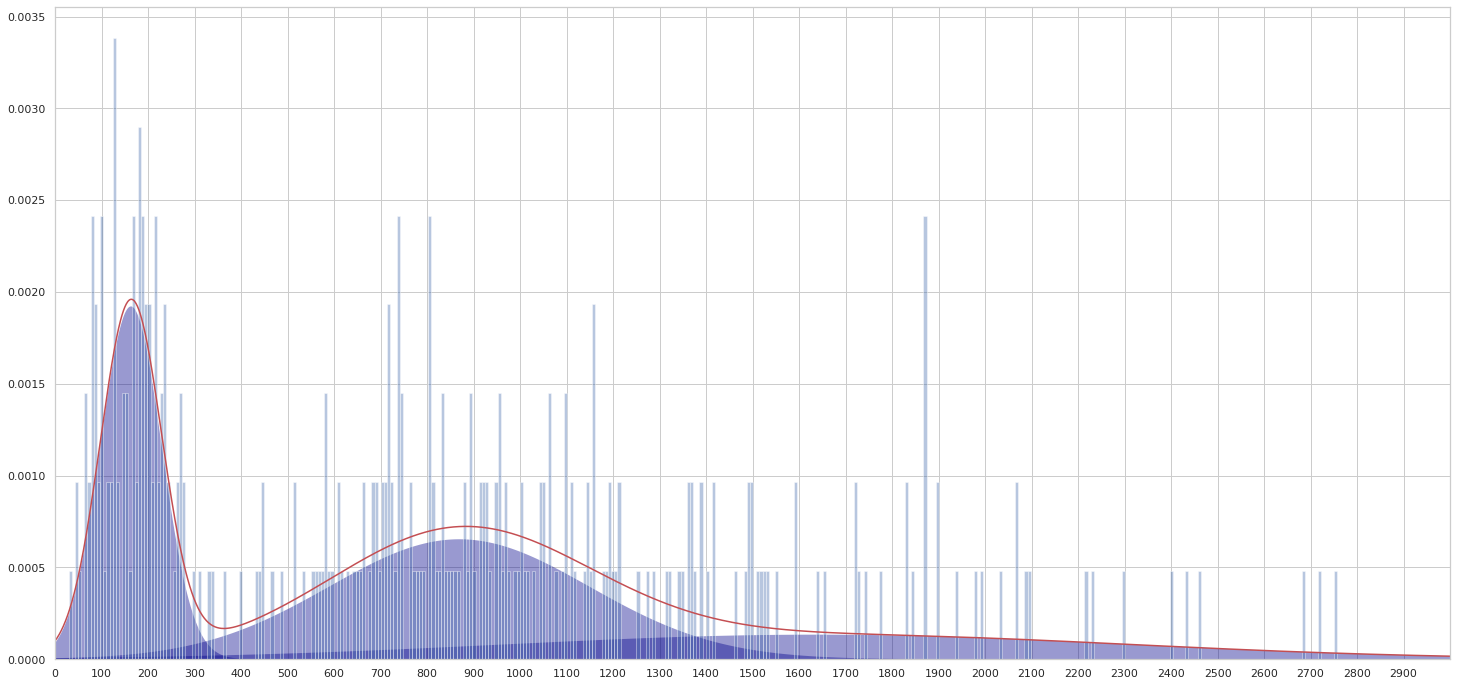

In [282]:
# 5 wpm user performance group
# Gaussian fitting of autocorrections and predictions 

Apply_Gaussian_mixture_models_2(log_comb_ite_with_participants_ites.loc[log_comb_ite_with_participants_ites['user type 5'] == 5].iki,3,3000)

85: 28.5
90: 43.5
90: 264.0
85: 279.0
85: 2010.0000000000002
90: 2065.5
85: 366.0
90: 376.5
90: 1402.5
85: 1497.0


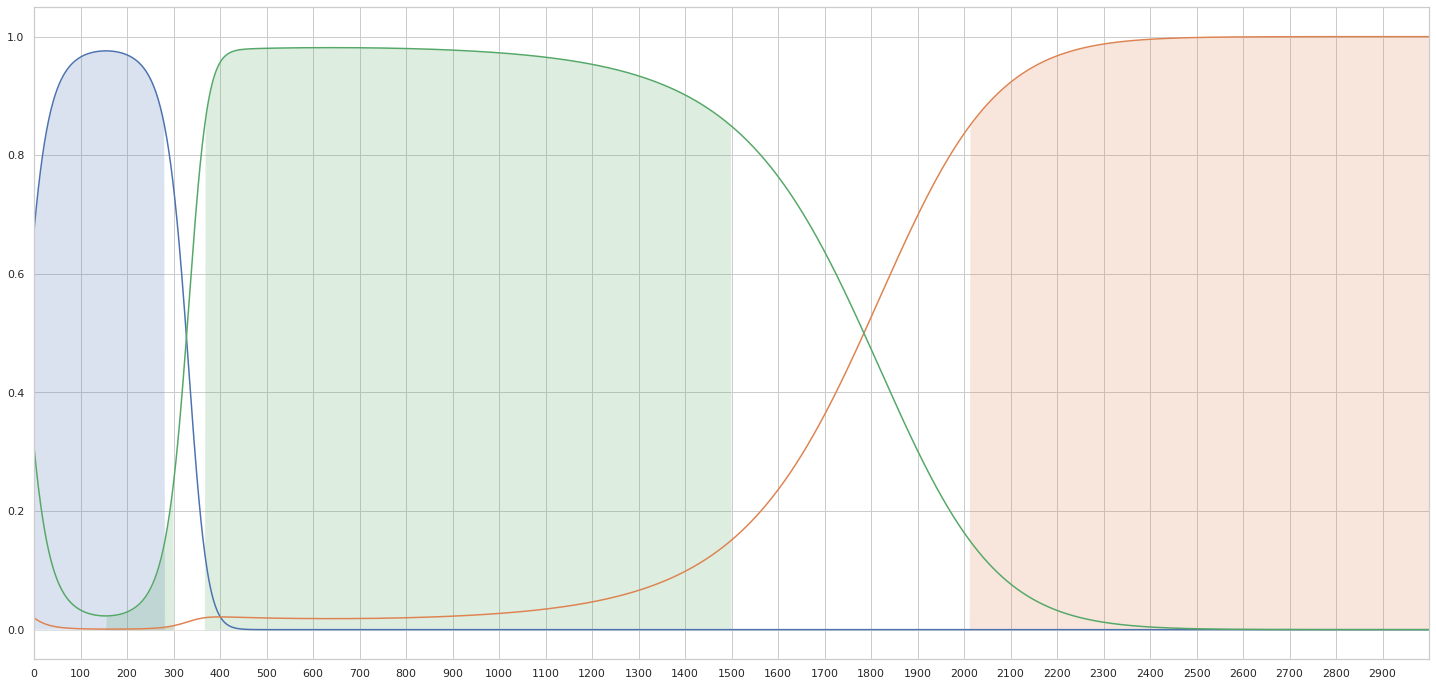

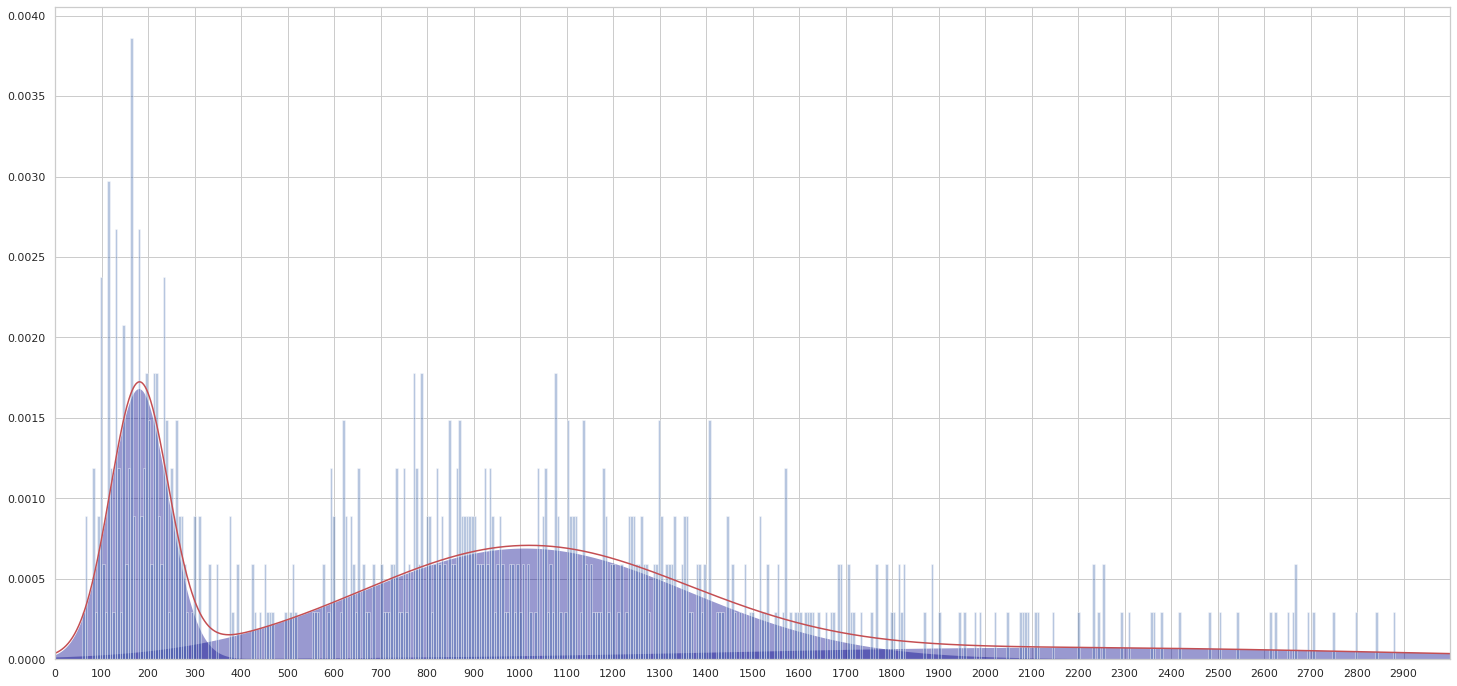

In [283]:
# 10 wpm user performance group
# Gaussian fitting of autocorrections and predictions 
Apply_Gaussian_mixture_models_2(log_comb_ite_with_participants_ites.loc[log_comb_ite_with_participants_ites['user type 5'] == 10].iki,3,3000)

85: 2079.0
90: 2128.5
85: 1023.0000000000001
90: 1108.5
90: 1488.0
85: 1590.0
90: 378.0
85: 463.5


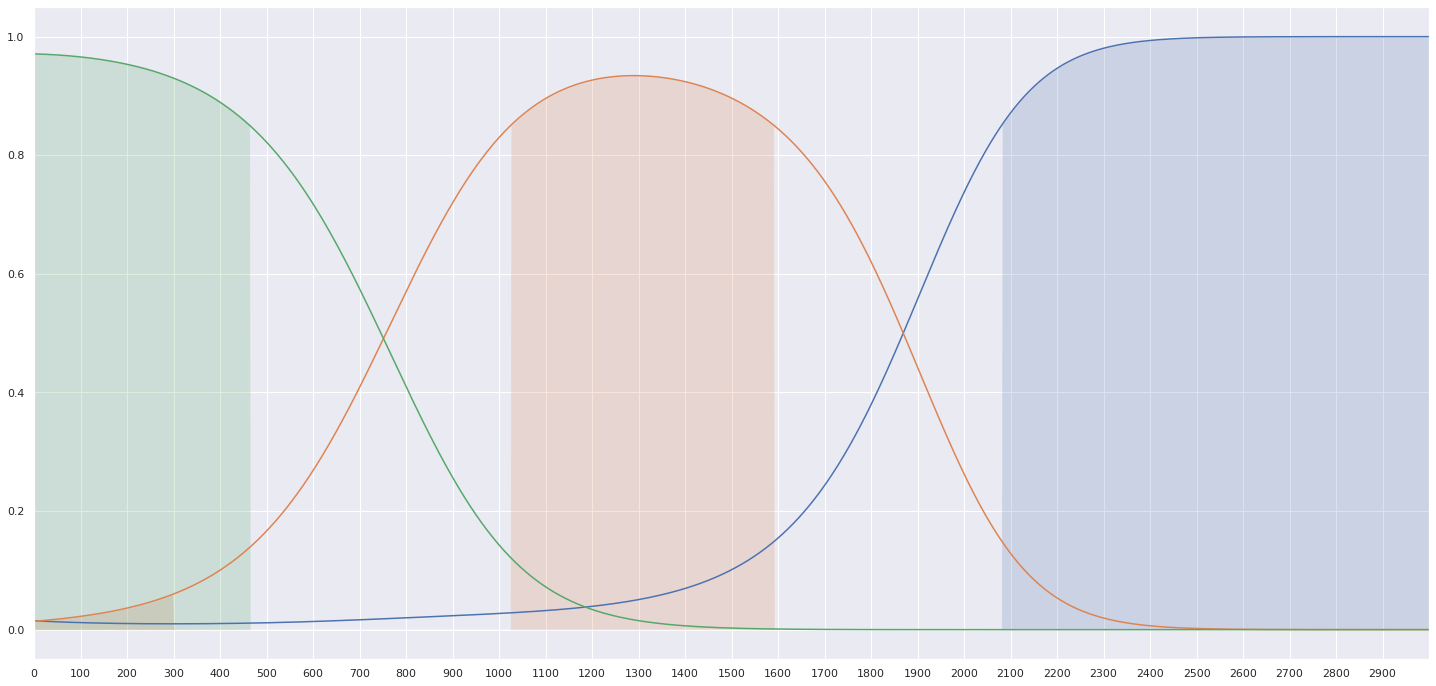

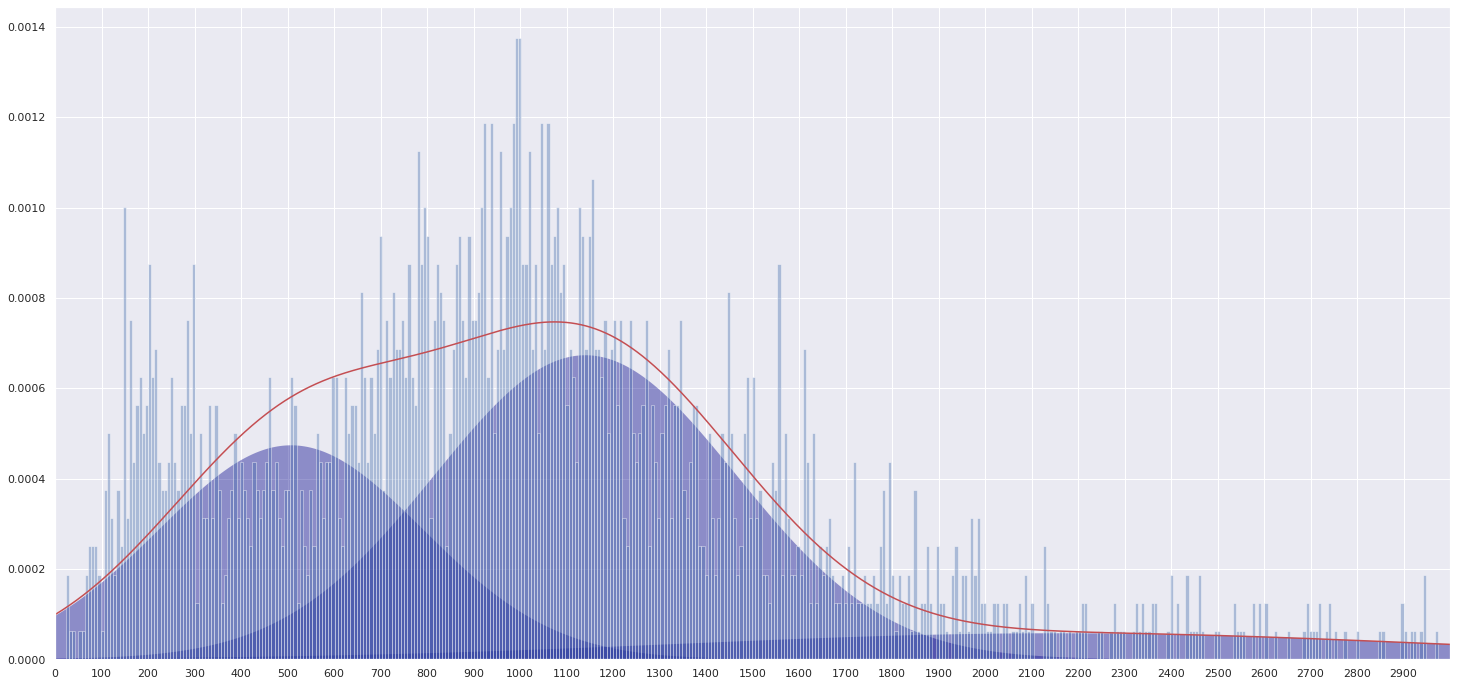

In [33]:
# 15 wpm user performance group
# Gaussian fitting of autocorrections and predictions 
Apply_Gaussian_mixture_models_2(log_comb_ite_with_participants_ites.loc[log_comb_ite_with_participants_ites['user type 5'] == 15].iki,3,3000)

85: 74.75
90: 116.35
90: 239.2
85: 281.45
85: 442.65000000000003
90: 462.79999999999995
90: 1175.2
85: 1283.75


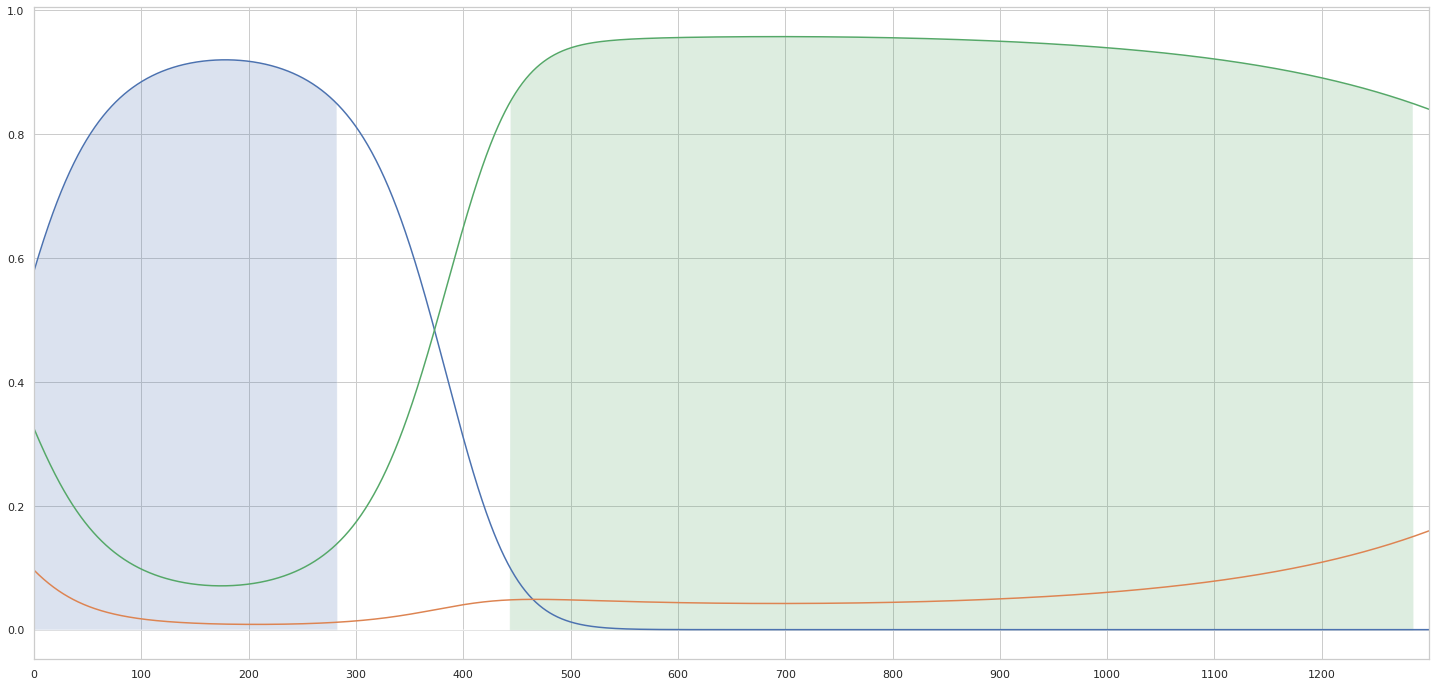

In [248]:
# 20 wpm user performance group
# Gaussian fitting of autocorrections and predictions 
Apply_Gaussian_mixture_models_2(log_comb_ite_with_participants_ites.loc[log_comb_ite_with_participants_ites['user type 5'] == 20].iki,3)

85: 25.35
90: 47.449999999999996
90: 272.34999999999997
85: 295.1
85: 417.95
90: 436.8
90: 1092.65
85: 1199.9


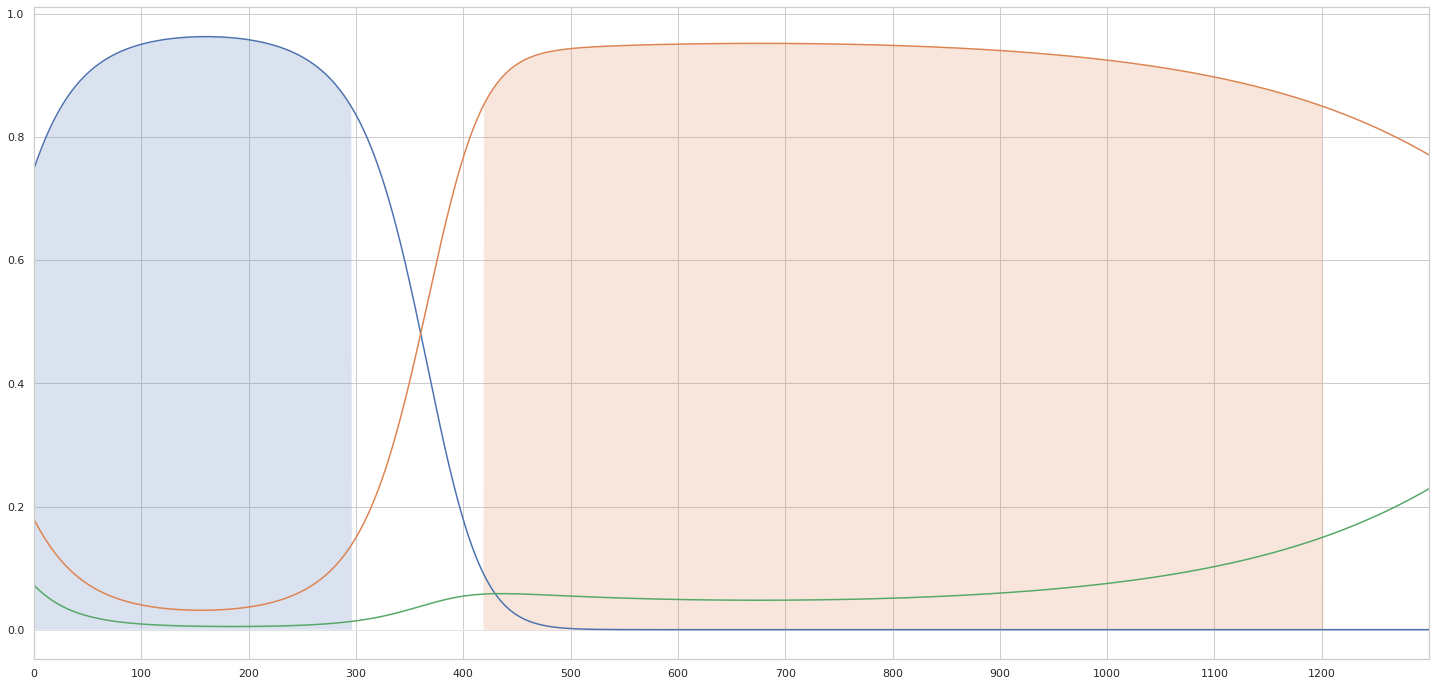

In [249]:
# 25 wpm user performance group
# Gaussian fitting of autocorrections and predictions 
Apply_Gaussian_mixture_models_2(log_comb_ite_with_participants_ites.loc[log_comb_ite_with_participants_ites['user type 5'] == 25].iki,3)

85: 395.2
90: 412.1
90: 1059.5
85: 1167.4
85: 8.45
90: 25.35
90: 275.59999999999997
85: 292.5


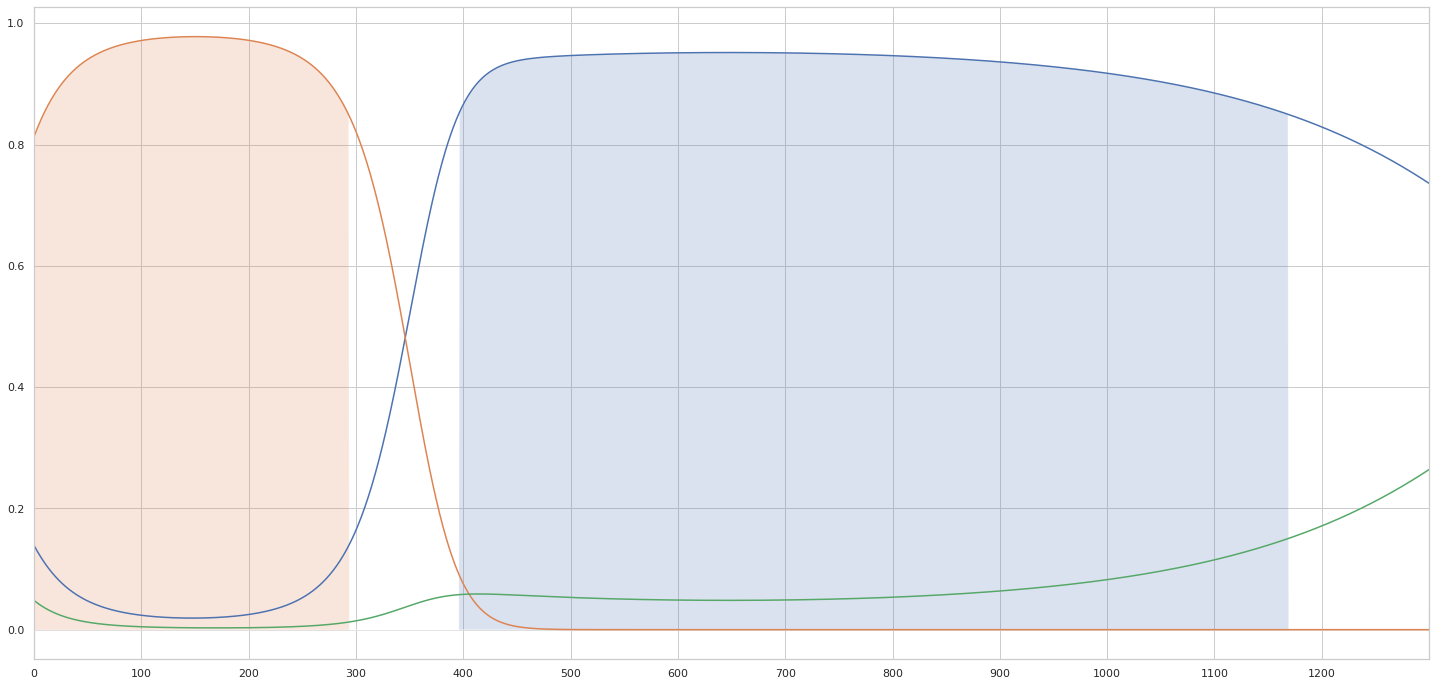

In [250]:
# 30 wpm user performance group
# Gaussian fitting of autocorrections and predictions 
Apply_Gaussian_mixture_models_2(log_comb_ite_with_participants_ites.loc[log_comb_ite_with_participants_ites['user type 5'] == 30].iki,3)

90: 282.0
85: 297.0
85: 397.0
90: 420.0
90: 904.0
85: 1045.0
85: 1593.0
90: 1645.0


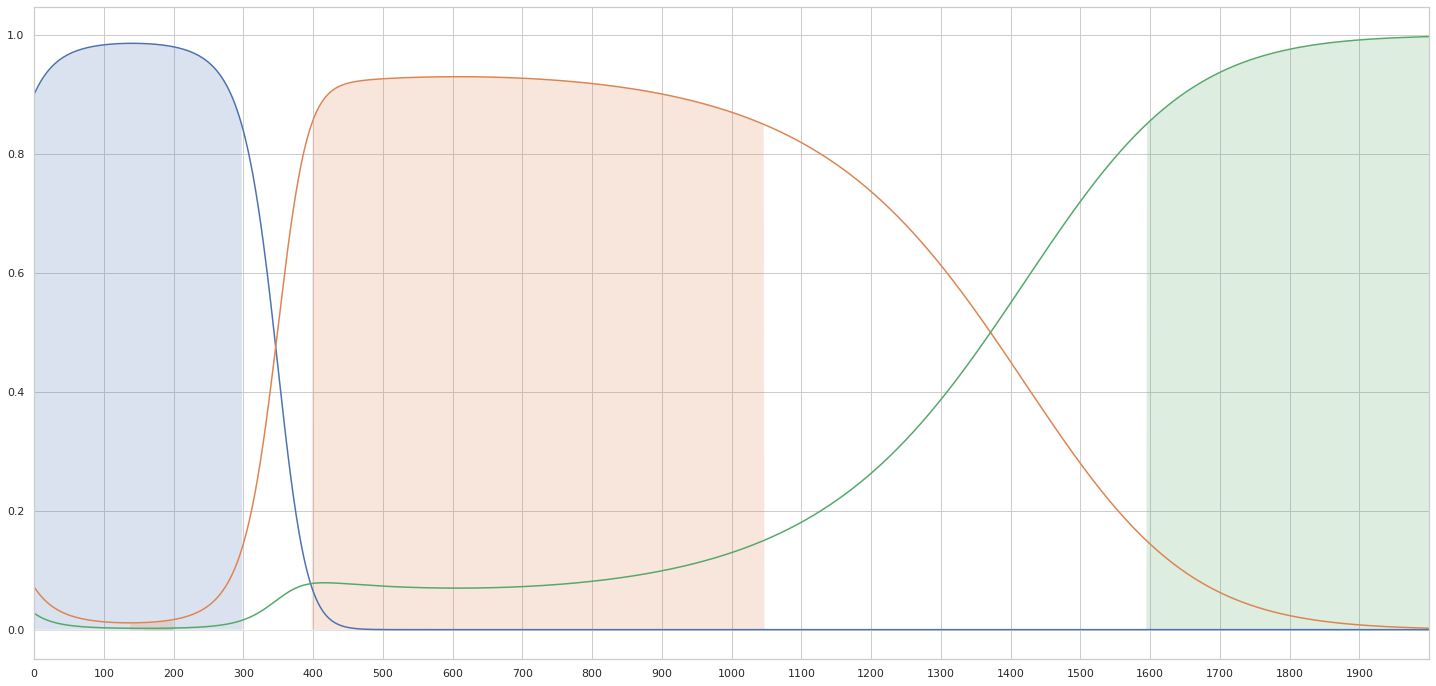

In [251]:
# 35 wpm user performance group
# Gaussian fitting of autocorrections and predictions 
Apply_Gaussian_mixture_models_2(log_comb_ite_with_participants_ites.loc[log_comb_ite_with_participants_ites['user type 5'] == 35].iki,3,2000)

90: 269.0
85: 282.0
85: 376.0
90: 408.0
90: 701.0
85: 900.0
85: 1511.0
90: 1566.0


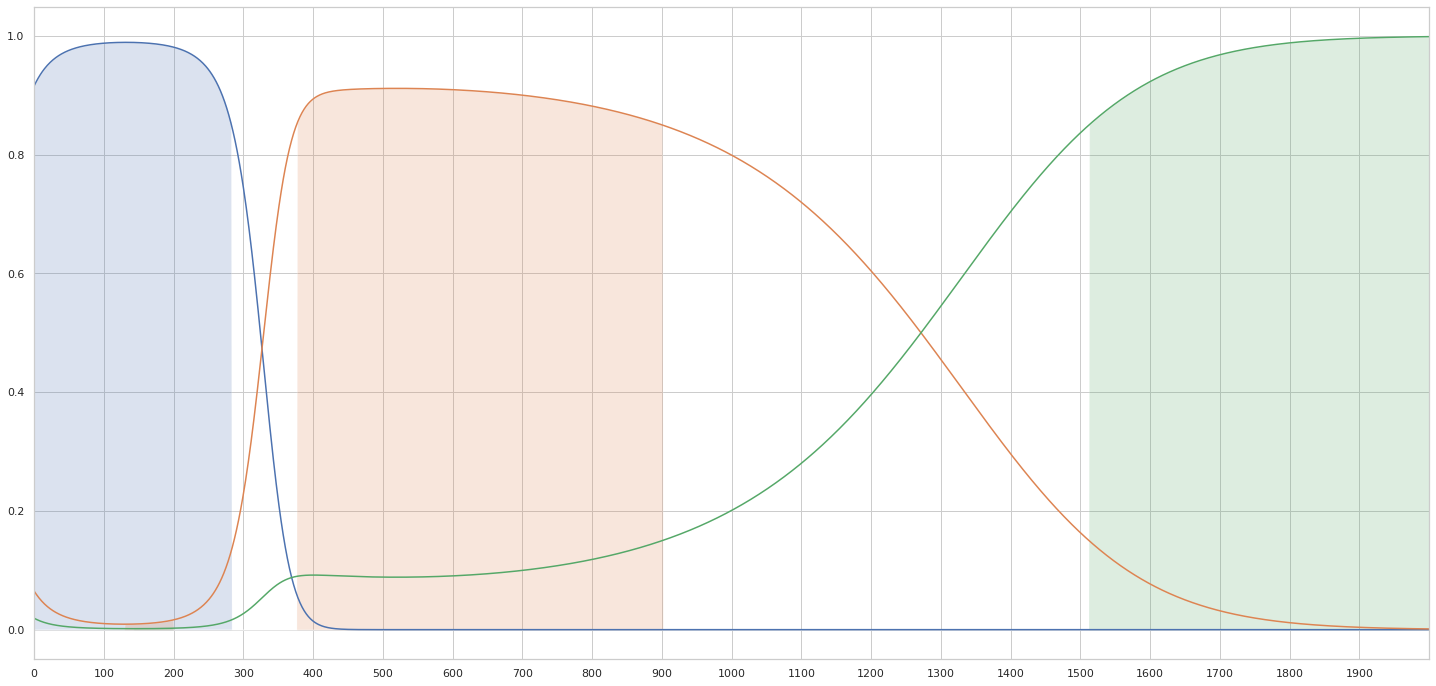

In [252]:
# 40 wpm user performance group
# Gaussian fitting of autocorrections and predictions 
Apply_Gaussian_mixture_models_2(log_comb_ite_with_participants_ites.loc[log_comb_ite_with_participants_ites['user type 5'] == 40].iki,3,2000)

90: 264.0
85: 276.0
85: 1388.8
90: 1444.8
85: 363.2
90: 387.2
90: 583.1999999999999
85: 775.1999999999999


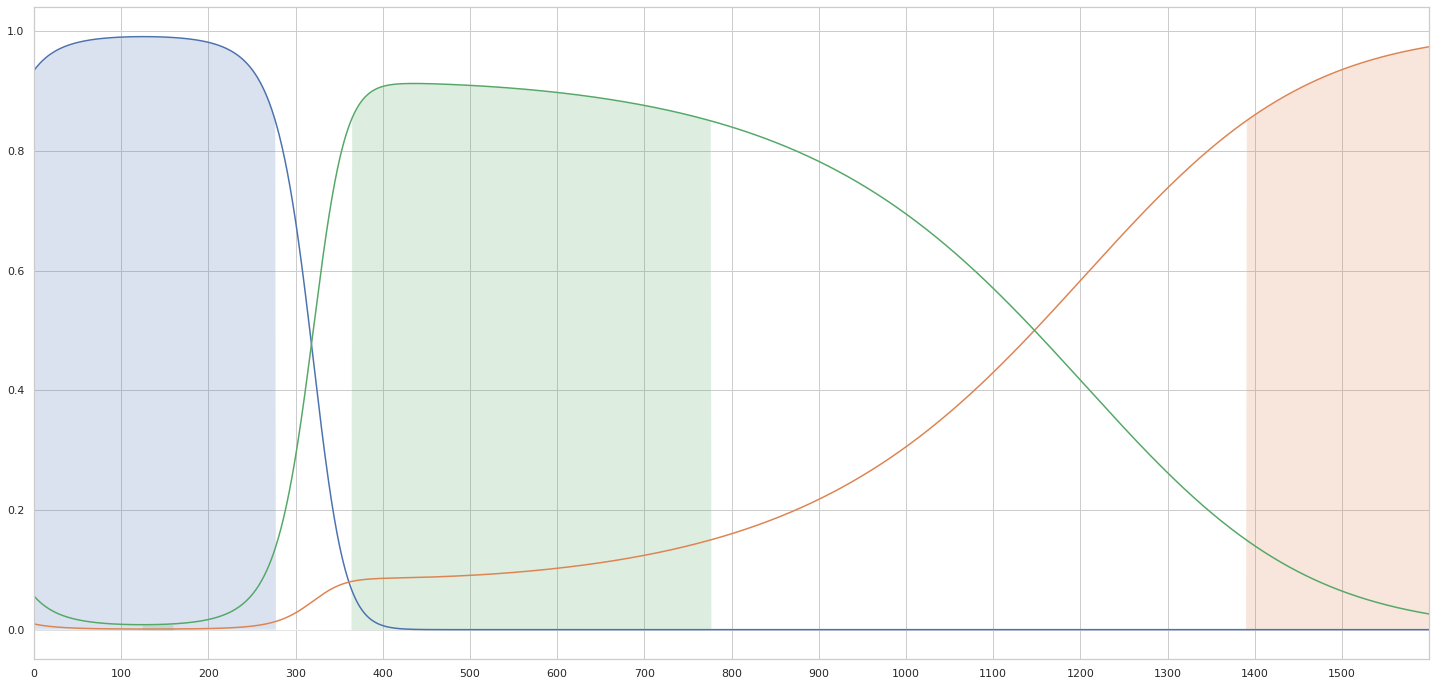

In [253]:
# 45 wpm user performance group
# Gaussian fitting of autocorrections and predictions 
Apply_Gaussian_mixture_models_2(log_comb_ite_with_participants_ites.loc[log_comb_ite_with_participants_ites['user type 5'] == 45].iki,3,1600)

90: 257.25
85: 268.5
85: 366.75
85: 693.0
85: 1350.0
90: 1403.25


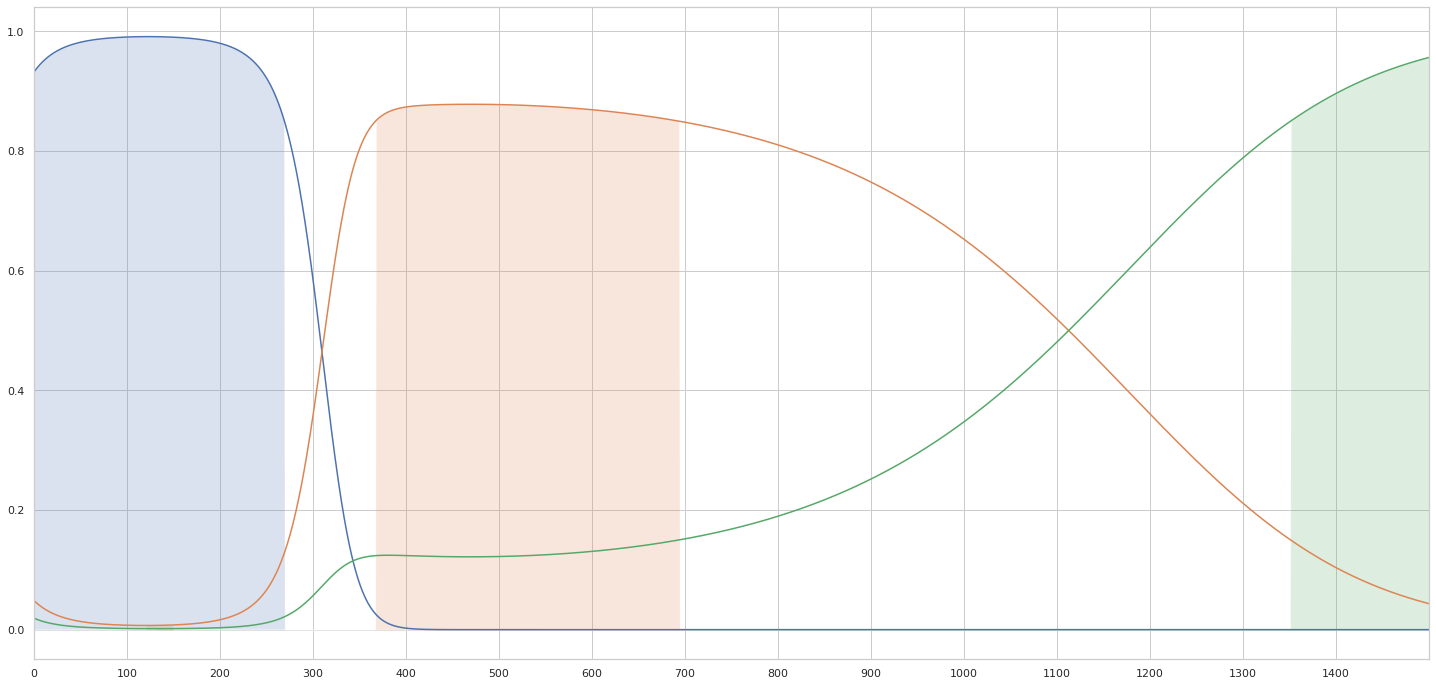

In [254]:
# 50 wpm user performance group
# Gaussian fitting of autocorrections and predictions 
Apply_Gaussian_mixture_models_2(log_comb_ite_with_participants_ites.loc[log_comb_ite_with_participants_ites['user type 5'] == 50].iki,3,1500)

90: 244.5
85: 255.5
85: 951.5
90: 989.5
85: 330.5
90: 348.5
90: 447.5
85: 549.0


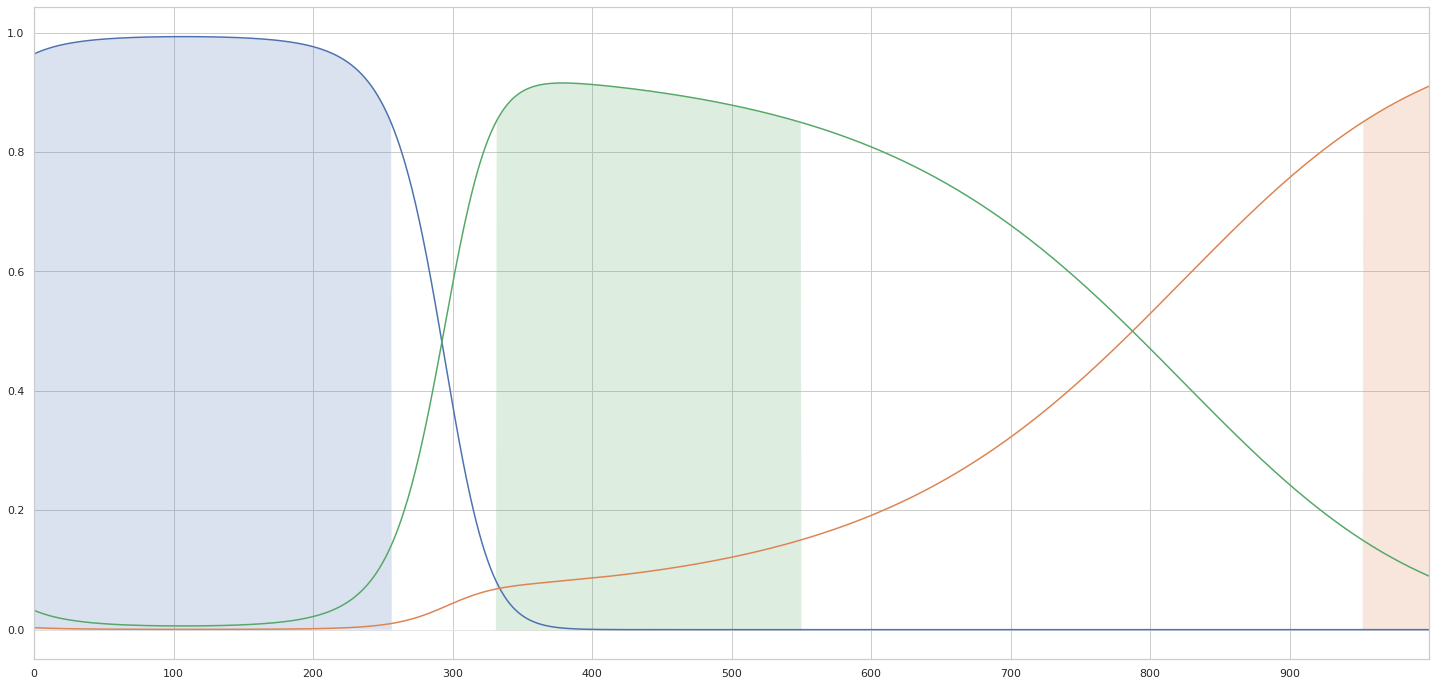

In [255]:
# 55 wpm user performance group
# Gaussian fitting of autocorrections and predictions 
Apply_Gaussian_mixture_models_2(log_comb_ite_with_participants_ites.loc[log_comb_ite_with_participants_ites['user type 5'] == 55].iki,3,1000)

90: 234.5
85: 245.0
85: 933.5
90: 968.0
85: 316.0
90: 330.0
90: 488.0
85: 574.5


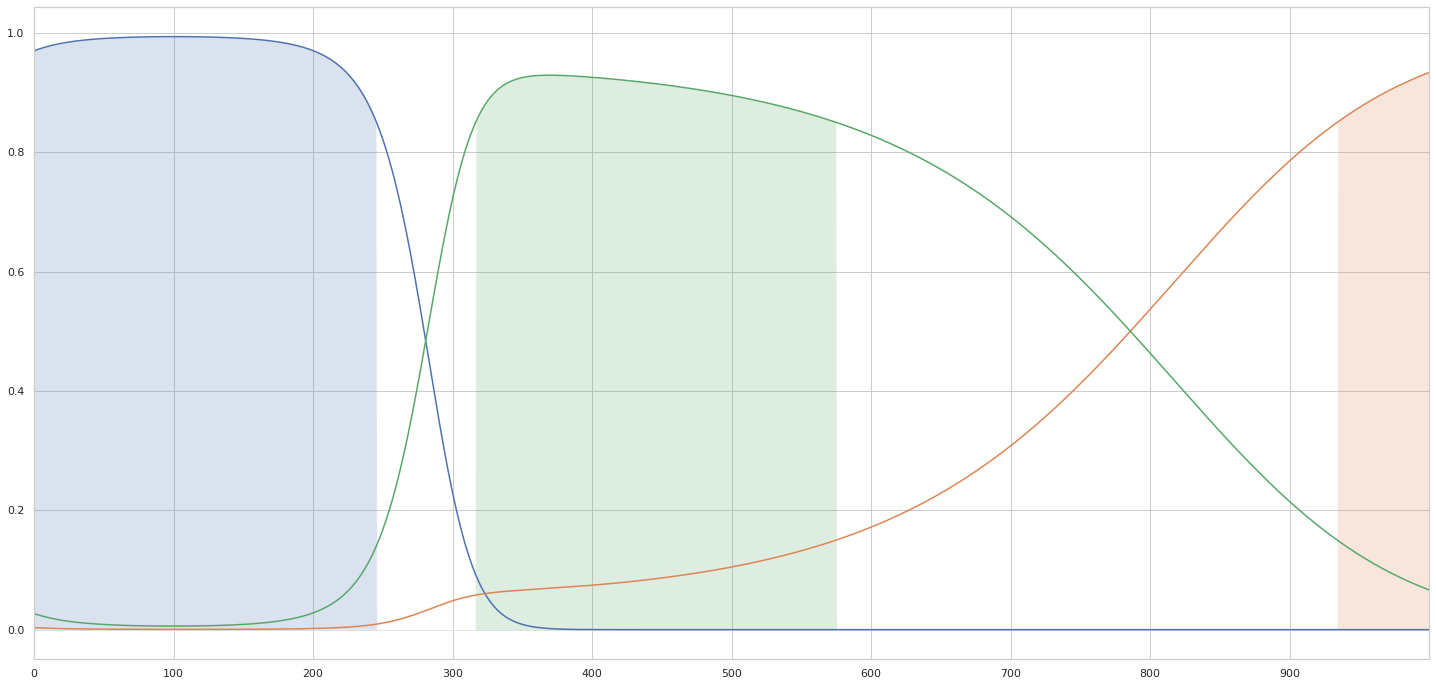

In [256]:
# 60 wpm user performance group
# Gaussian fitting of autocorrections and predictions 
Apply_Gaussian_mixture_models_2(log_comb_ite_with_participants_ites.loc[log_comb_ite_with_participants_ites['user type 5'] == 60].iki,3,1000)

85: 290.8
90: 299.2
90: 477.59999999999997
85: 515.2
90: 216.8
85: 227.2
85: 715.6
90: 736.8000000000001


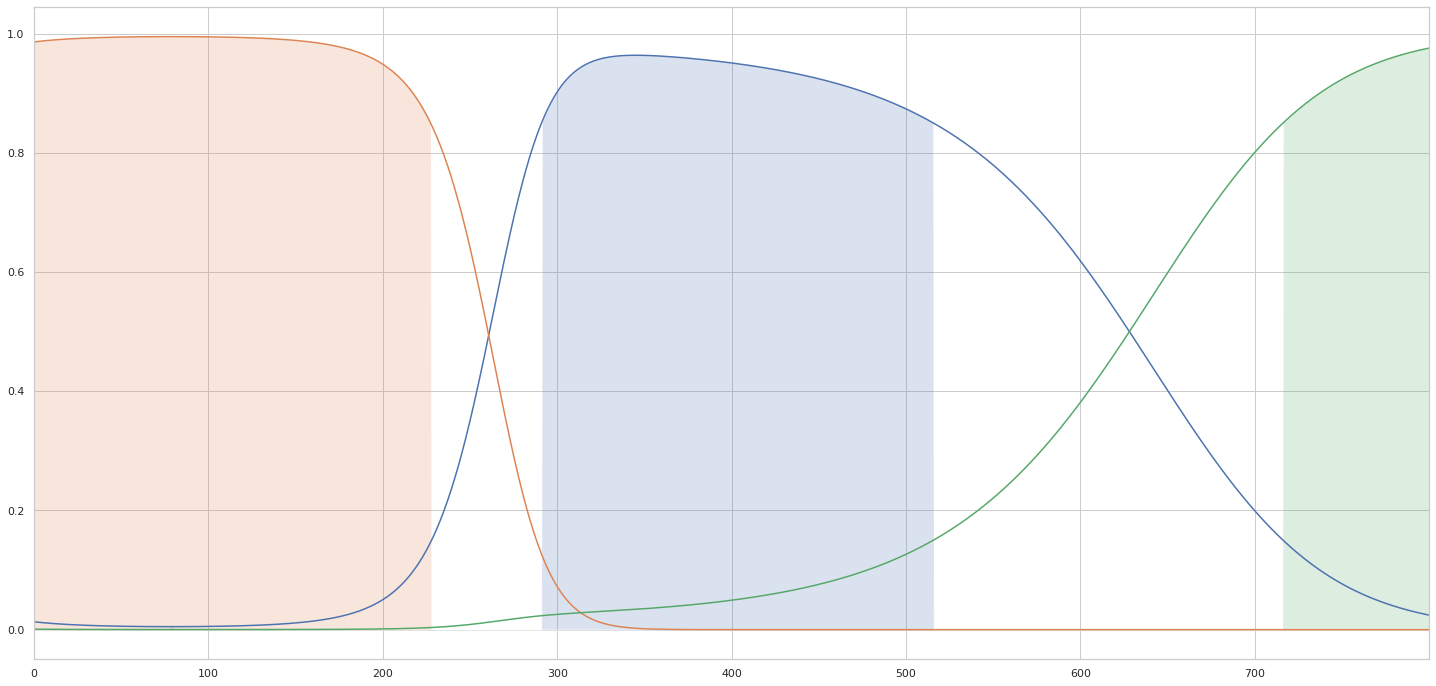

In [257]:
# 65 wpm user performance group
# Gaussian fitting of autocorrections and predictions 
Apply_Gaussian_mixture_models_2(log_comb_ite_with_participants_ites.loc[log_comb_ite_with_participants_ites['user type 5'] == 65].iki,3,800)

85: 144.29999999999998
90: 149.7
90: 230.1
85: 238.5
85: 285.0
90: 289.8
85: 6.0
90: 11.4
90: 93.0
85: 99.9


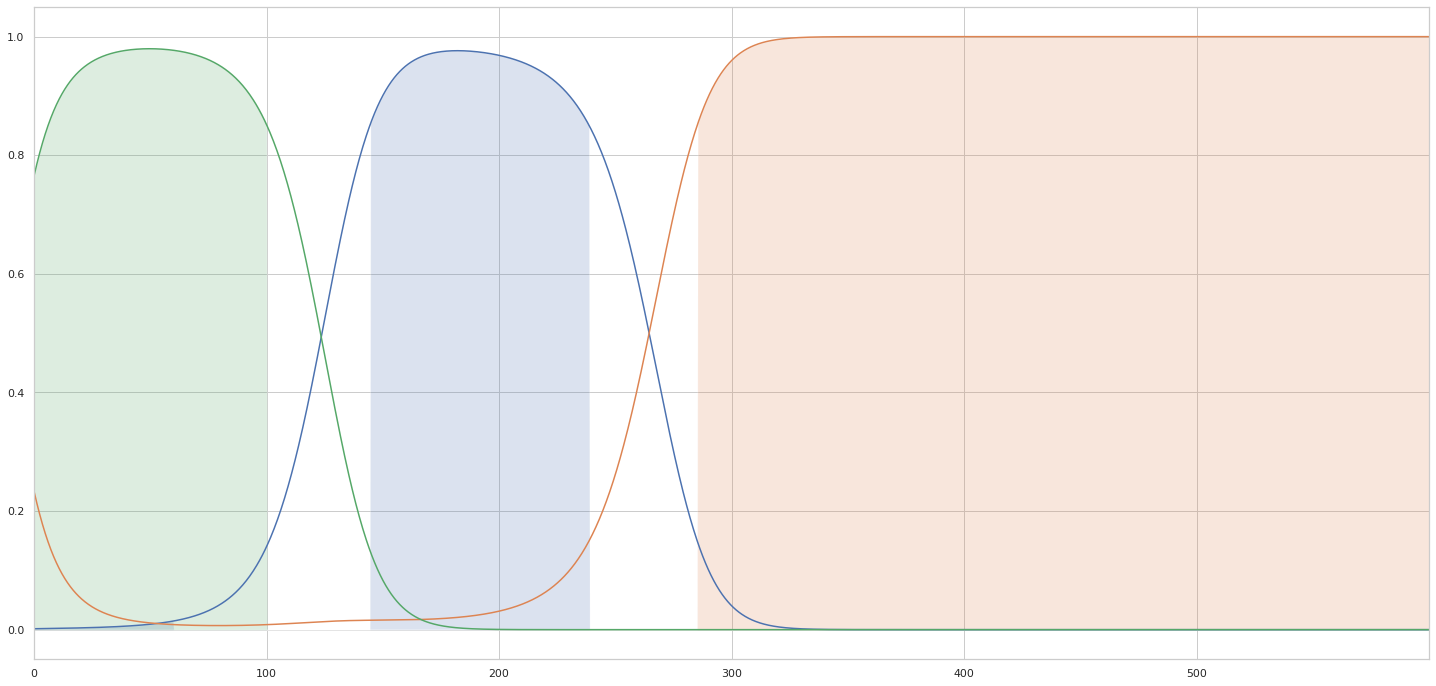

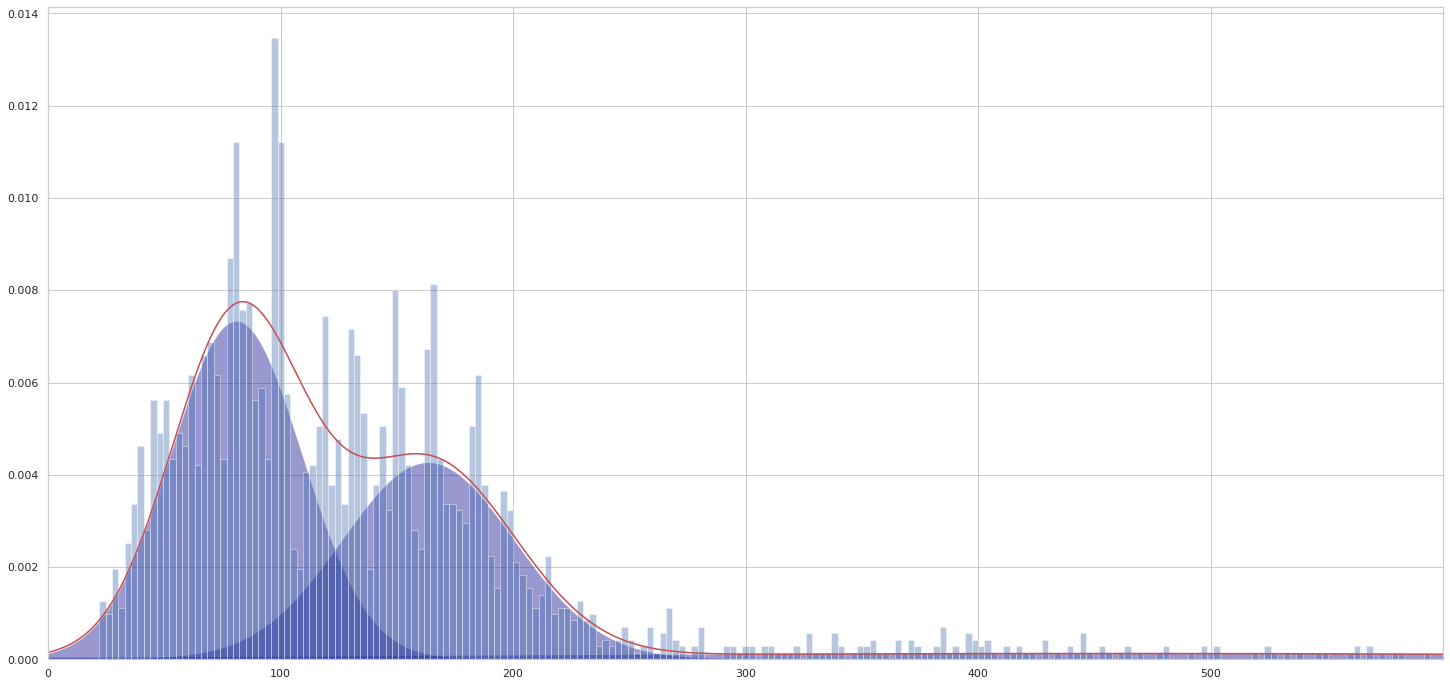

In [268]:
# 70 wpm user performance group
# Gaussian fitting of autocorrections and predictions 
Apply_Gaussian_mixture_models_2(log_comb_ite_with_participants_ites.loc[log_comb_ite_with_participants_ites['user type 5'] == 70].iki,3,600)

85: 130.75
90: 135.25
90: 218.25
85: 225.25
90: 88.5
85: 94.25
85: 266.0
90: 270.5


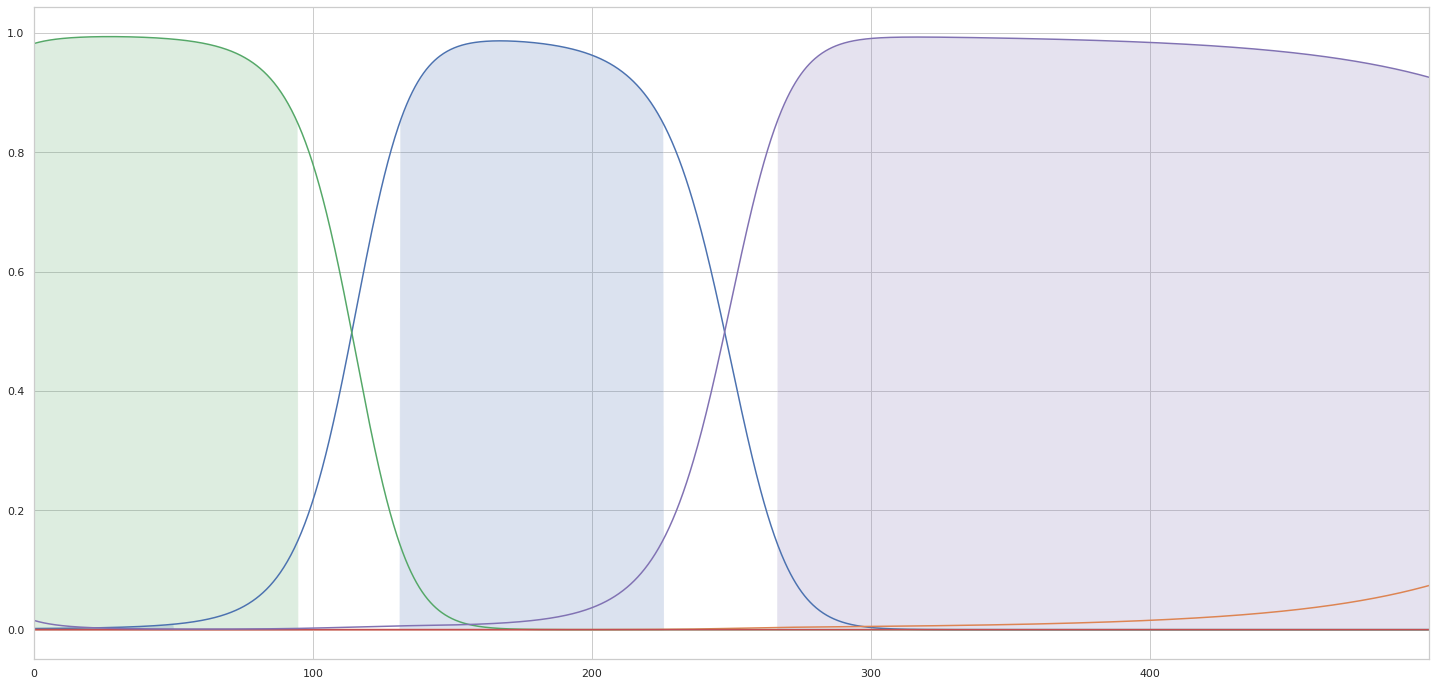

In [259]:
# 75 wpm user performance group
# Gaussian fitting of autocorrections and predictions 
Apply_Gaussian_mixture_models_2(log_comb_ite_with_participants_ites.loc[log_comb_ite_with_participants_ites['user type 5'] == 75].iki,5,500)

85: 1.5
90: 6.300000000000001
90: 91.5
85: 97.2
85: 266.1
90: 270.3
85: 135.9
90: 140.7
90: 222.0
85: 228.3


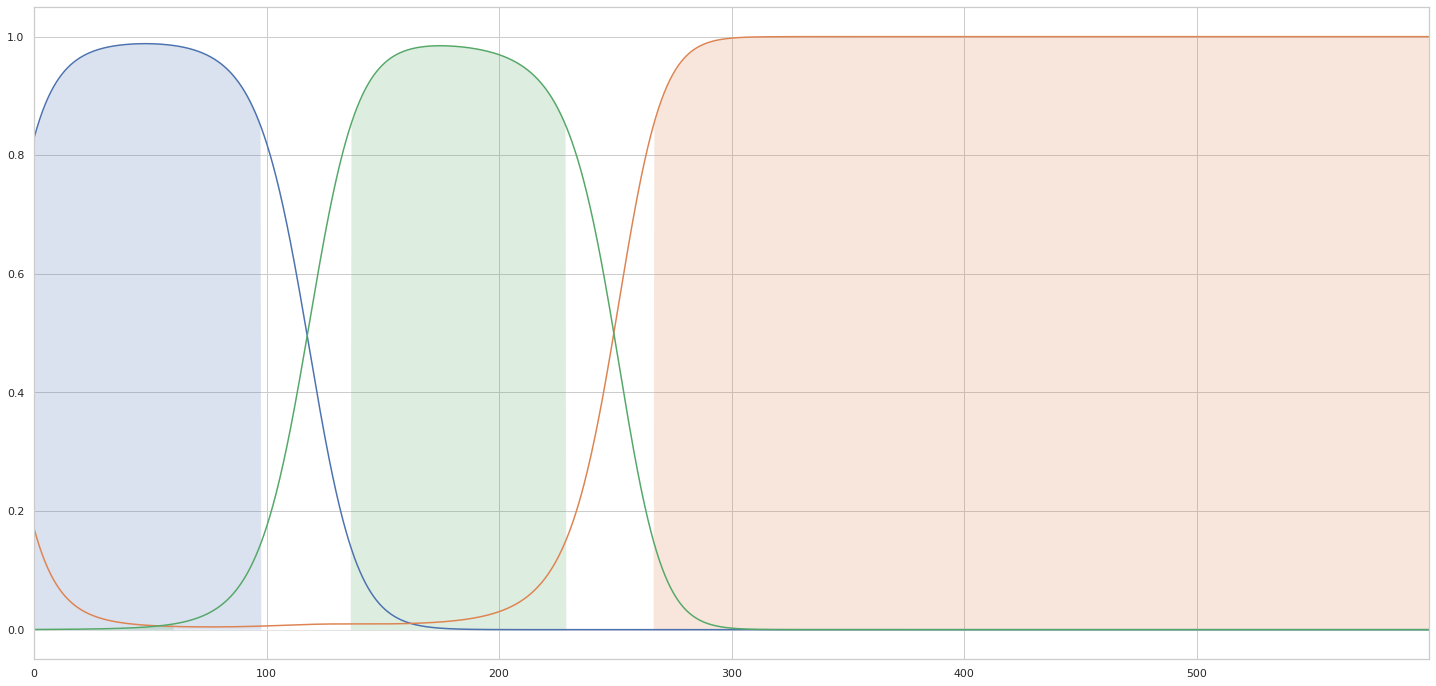

In [260]:
# 80 wpm user performance group
# Gaussian fitting of autocorrections and predictions 
Apply_Gaussian_mixture_models_2(log_comb_ite_with_participants_ites.loc[log_comb_ite_with_participants_ites['user type 5'] == 80].iki,3,600)

85: 7.8
90: 11.1
90: 73.2
85: 78.0
85: 244.79999999999998
90: 249.0
85: 105.6
90: 108.89999999999999
90: 201.0
85: 207.29999999999998


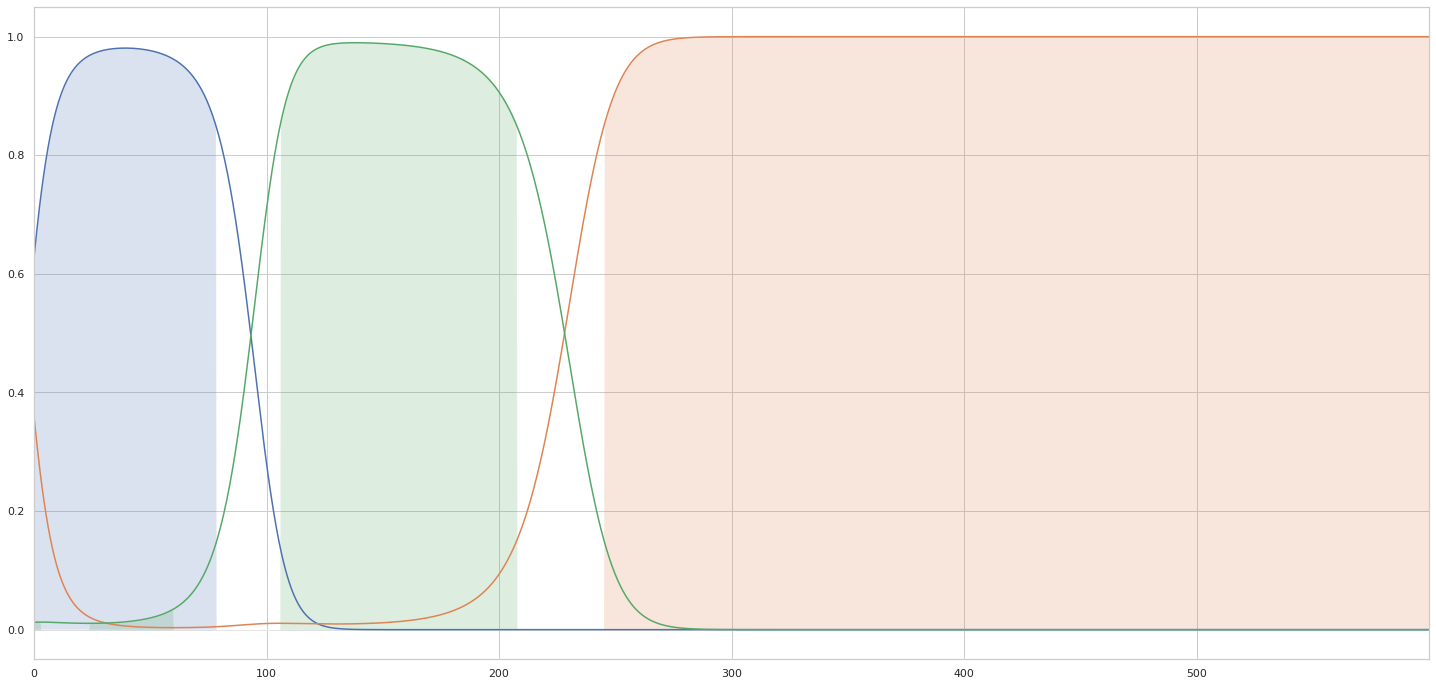

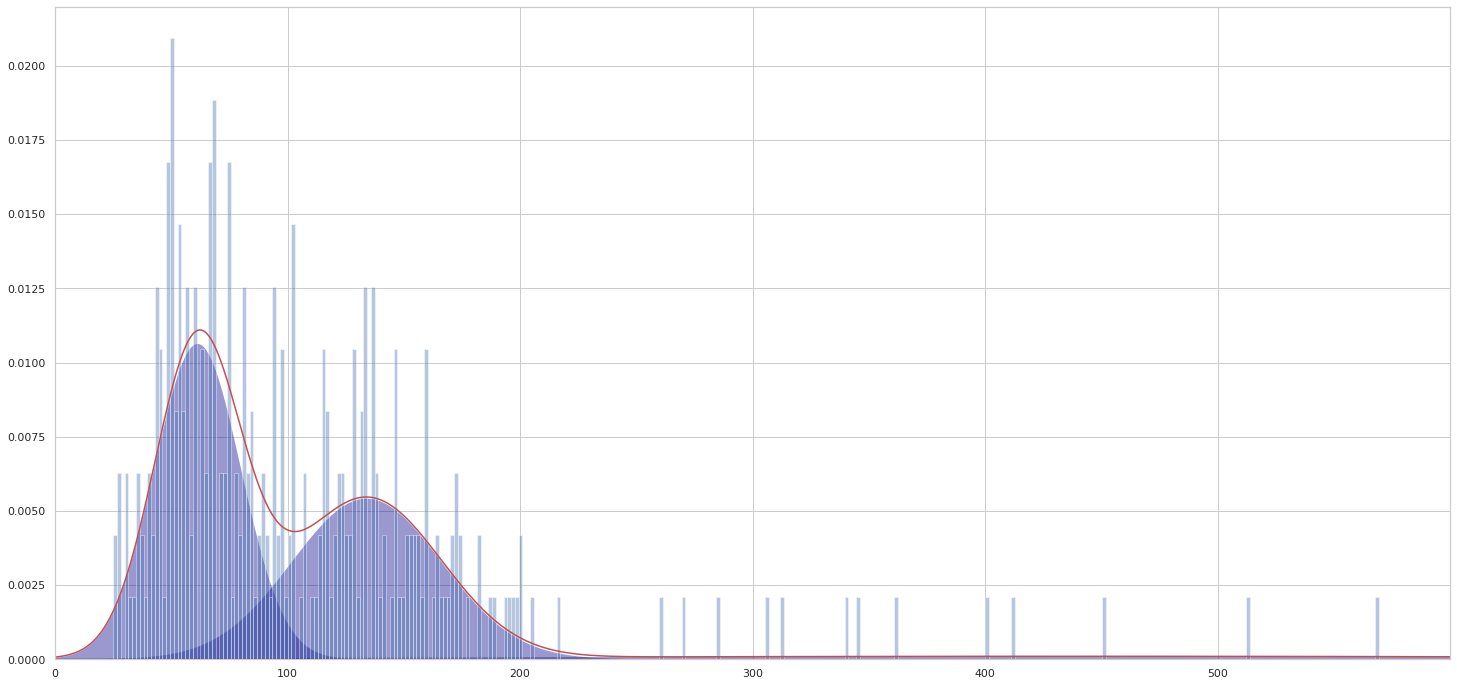

In [269]:
# 85 wpm user performance group
# Gaussian fitting of autocorrections and predictions 
Apply_Gaussian_mixture_models_2(log_comb_ite_with_participants_ites.loc[log_comb_ite_with_participants_ites['user type 5'] == 85].iki,3,600)

85: 123.89999999999999
90: 126.6
90: 201.9
85: 204.9
90: 100.80000000000001
85: 103.49999999999999
85: 224.7
90: 226.8


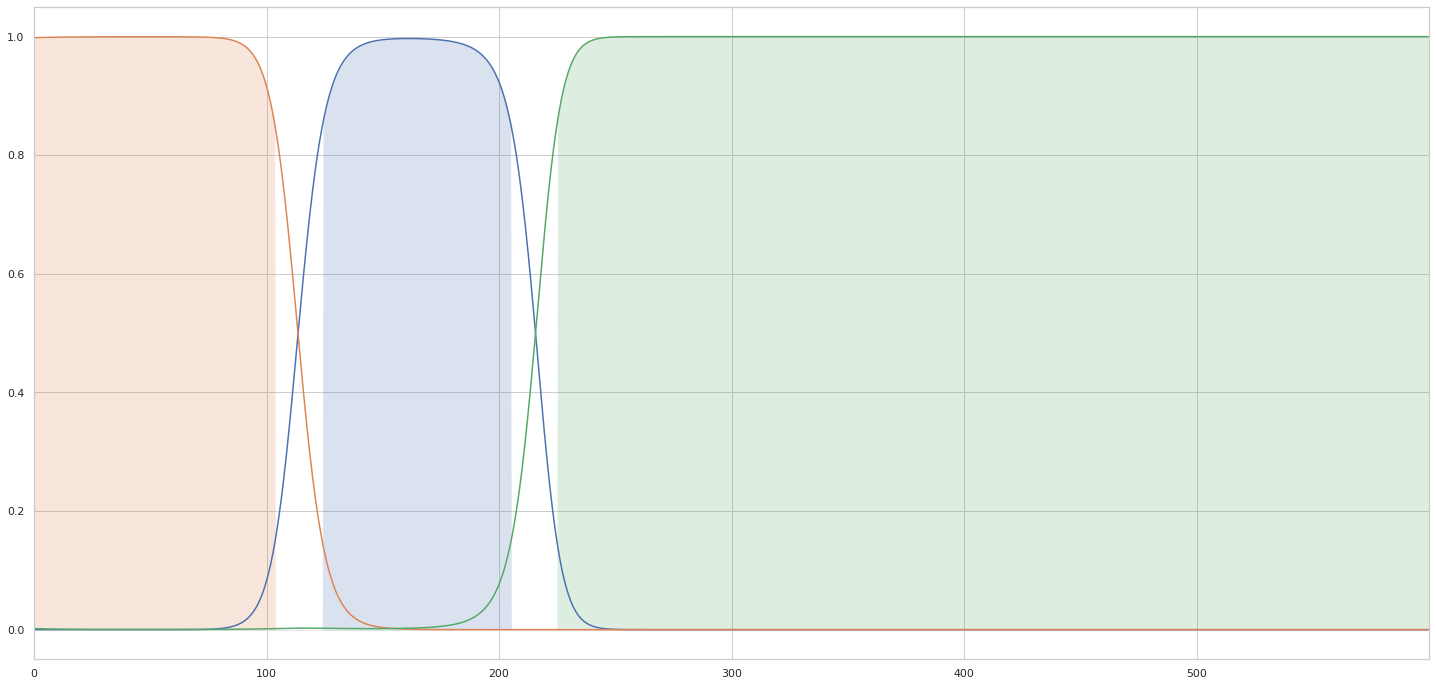

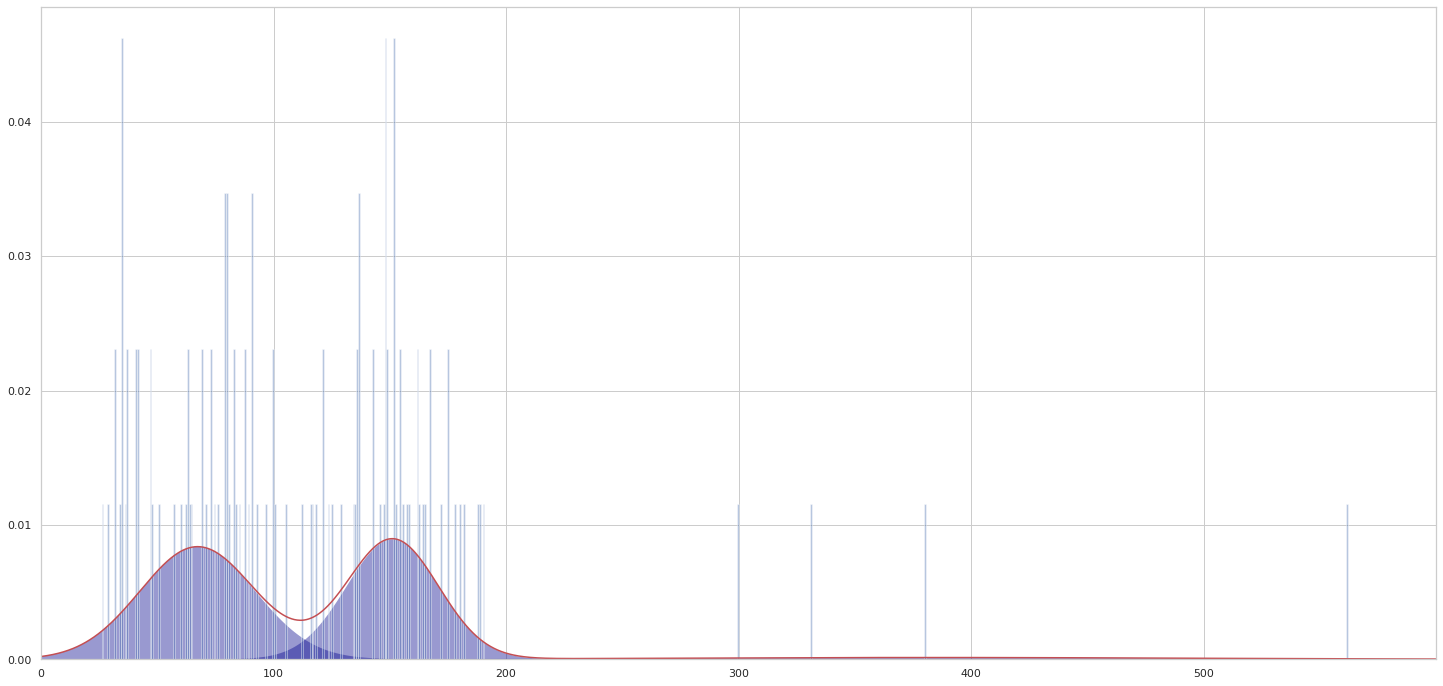

In [270]:
# 90 wpm user performance group
# Gaussian fitting of autocorrections and predictions 
Apply_Gaussian_mixture_models_2(log_comb_ite_with_participants_ites.loc[log_comb_ite_with_participants_ites['user type 5'] == 90].iki,3,600)

85: 118.8
90: 123.2
90: 11.799999999999999
90: 59.8
85: 72.2


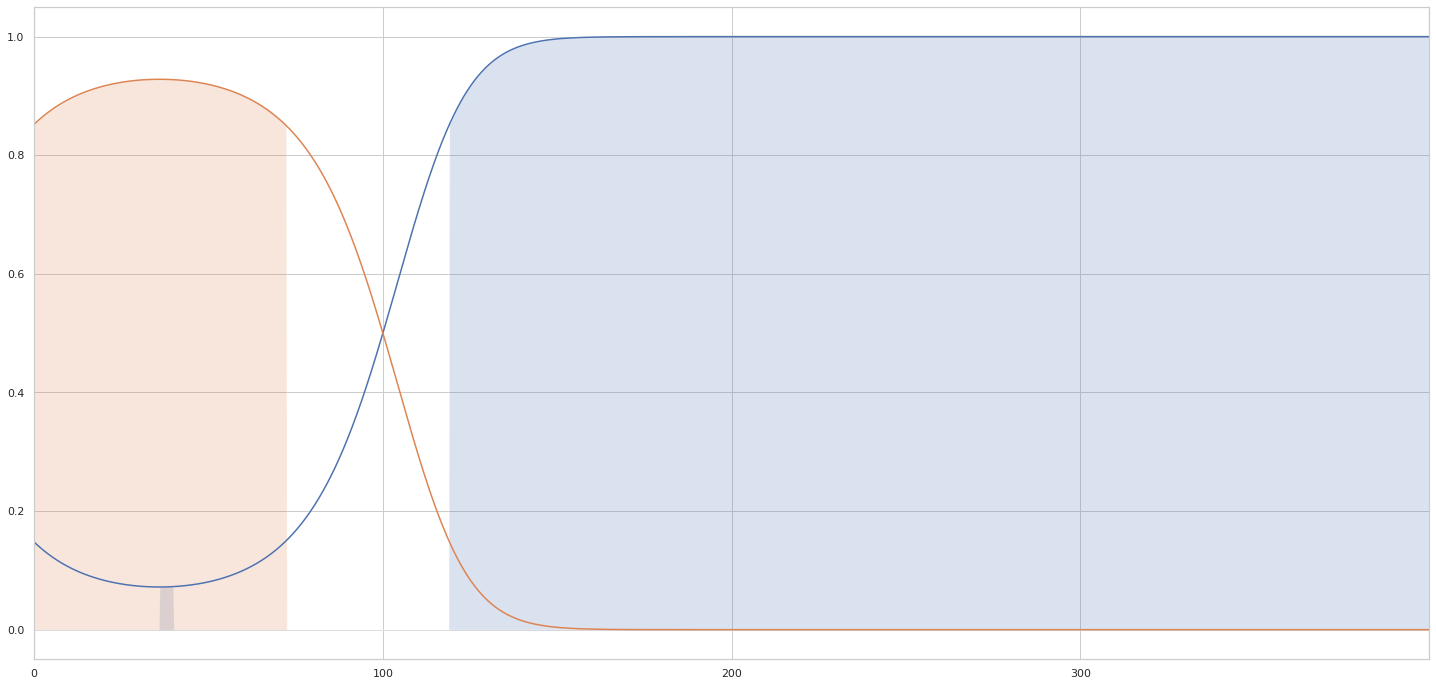

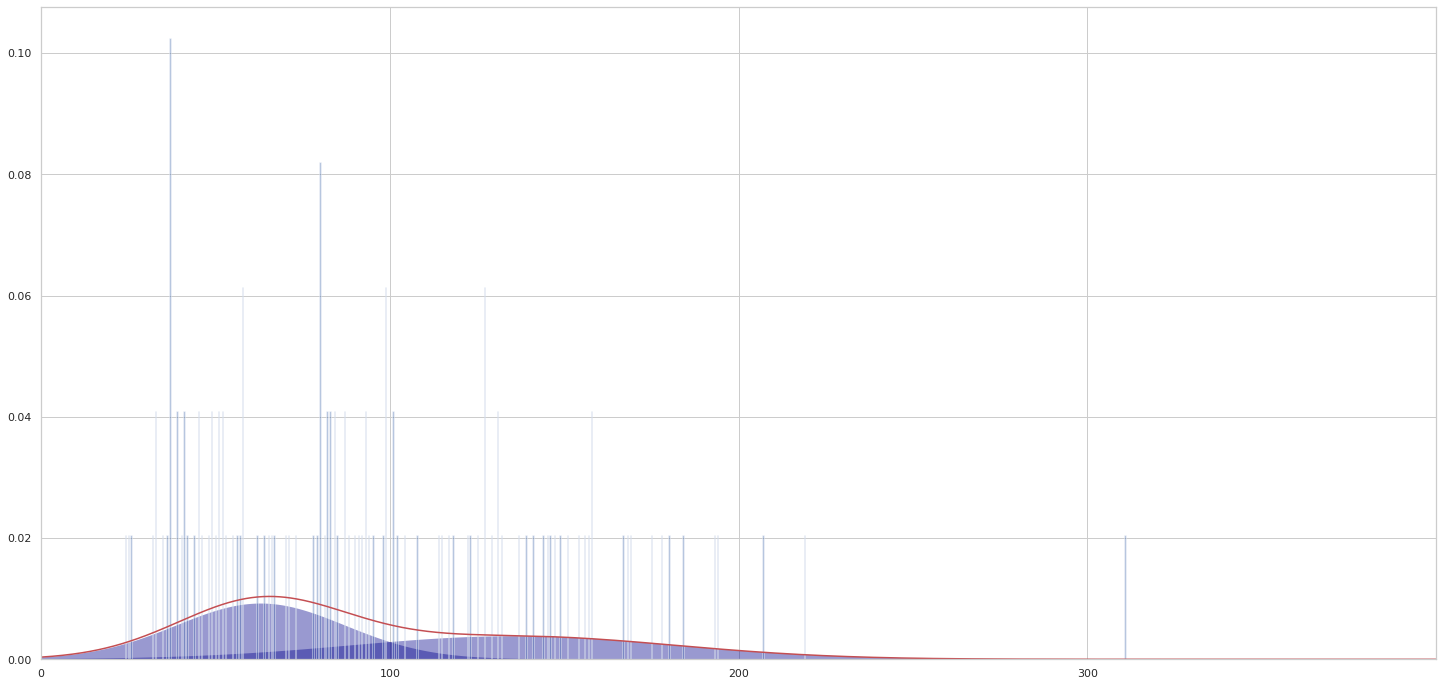

In [273]:
# 95 wpm user performance group
# Gaussian fitting of autocorrections and predictions 
Apply_Gaussian_mixture_models_2(log_comb_ite_with_participants_ites.loc[log_comb_ite_with_participants_ites['user type 5'] == 95].iki,2,400)

85: 128.0
90: 128.0
85: 128.6
90: 128.7


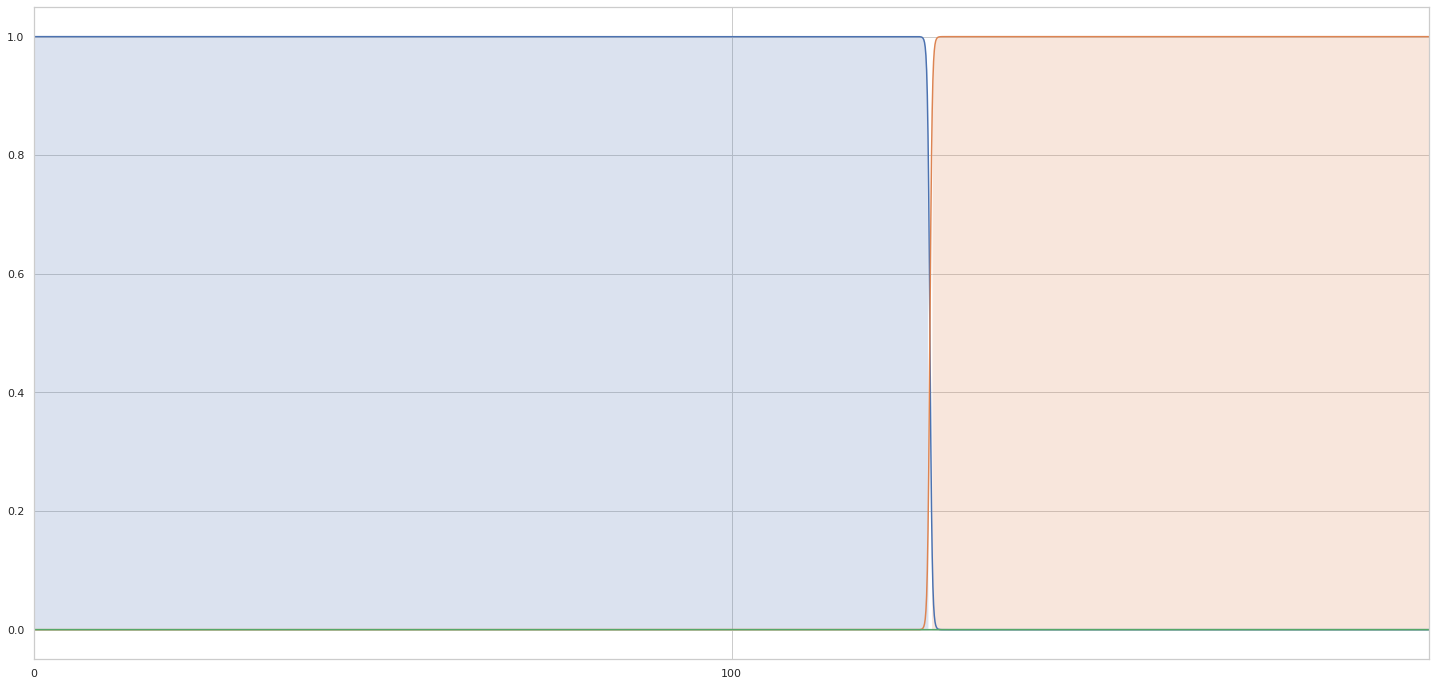

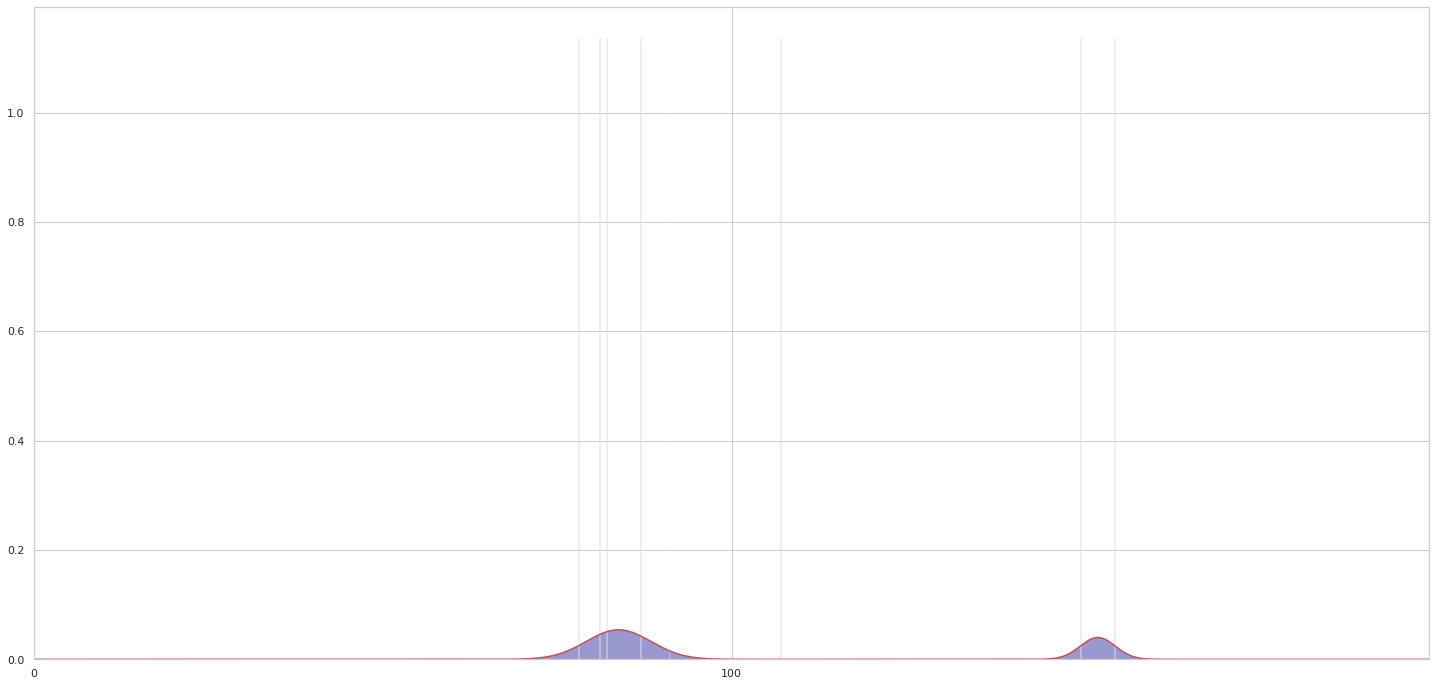

In [274]:
# 100 wpm user performance group
# Gaussian fitting of autocorrections and predictions 
Apply_Gaussian_mixture_models_2(log_comb_ite_with_participants_ites.loc[log_comb_ite_with_participants_ites['user type 5'] == 99].iki,3,200)

In [72]:
# Classification strategy

user_group = [5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]
thresholds = [800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,396,367,593,442,417,395,397,376,363,367,331,316,291,285,266,266,245,225,300,300,273,280,396,281,295,293,297,282,276,269,255,245,227,239,225,228,208,205,200,200]
threshold_types  = ['prediction','prediction','prediction','prediction','prediction','prediction','prediction','prediction','prediction','prediction','prediction','prediction','prediction','prediction','prediction','prediction','prediction','prediction','prediction','prediction','unclassified','unclassified','unclassified','unclassified','unclassified','unclassified','unclassified','unclassified','unclassified','unclassified','unclassified','unclassified','unclassified','unclassified','unclassified','unclassified','unclassified','unclassified','unclassified','unclassified', 'autocorr','autocorr','autocorr','autocorr','autocorr','autocorr','autocorr','autocorr','autocorr','autocorr','autocorr','autocorr','autocorr','autocorr','autocorr','autocorr','autocorr','autocorr','autocorr','autocorr']

df = pd.DataFrame(data=[user_group,thresholds,threshold_types])
df = df.T
df = df.rename(columns={0: "user_group", 1: "iki",2: "threshold_types"})

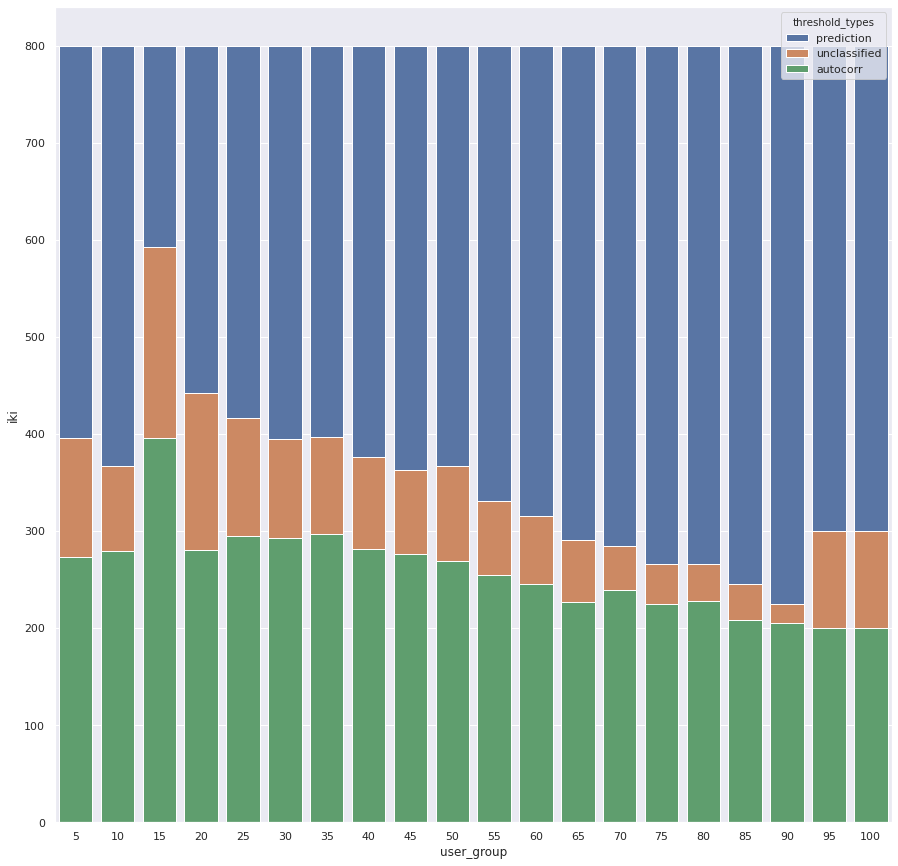

In [73]:
sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(15,15)})
sns.barplot(x=df.user_group,y=df.iki,hue=df.threshold_types,data=df,dodge=False)

In [70]:
Analyze_user_group(log_comb_ite_with_participants_ites)

---------------------------------------------------------------------------------------------------------------
  User Group   | Sample Size  | % Autocorr    | % Predict     | % Undef.      | Threshold Min | Threshold Max  
---------------------------------------------------------------------------------------------------------------
  5 WPM        |          305 |        31.475 |         66.23 |         2.295 |           273 |           396  
  10 WPM       |          644 |        28.727 |         69.41 |         1.863 |           280 |           367  
  15 WPM       |         2564 |        21.763 |        71.373 |         6.864 |           396 |           593  
  20 WPM       |         6326 |        19.238 |        71.783 |         8.979 |           281 |           442  
  25 WPM       |        12239 |        33.344 |        60.977 |         5.679 |           295 |           417  
  30 WPM       |        17186 |        46.683 |         48.33 |         4.987 |           293 |         

In [71]:
Analyze_losses_with_old_thresholds(log_comb_ite_with_participants_ites)

---------------------------------------------------------------------------------------------------------------
  User Group   | Sample Size  | % Autocorr    | % Predict     | % Undef.      | Threshold Min | Threshold Max  
---------------------------------------------------------------------------------------------------------------
  5 WPM        |          305 |        34.098 |        63.934 |         1.968 |           400 |           500  
  10 WPM       |          644 |        31.522 |        66.925 |         1.553 |           400 |           500  
  15 WPM       |         2564 |        22.075 |         74.61 |         3.315 |           400 |           500  
  20 WPM       |         6326 |        26.478 |        69.475 |         4.047 |           400 |           500  
  25 WPM       |        12239 |        38.606 |        58.256 |         3.138 |           400 |           500  
  30 WPM       |        17186 |        51.914 |        44.944 |         3.142 |           400 |         

In [359]:
log_comb_ite_with_participants_ites.shape[0]

139022